# Set-up


Sources for pre-trained models on CIFAR-10

https://github.com/chenyaofo/pytorch-cifar-models/tree/master/pytorch_cifar_models

https://github.com/huckiyang/PyTorch-CIFAR10

https://github.com/huyvnphan/PyTorch_CIFAR10



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import time
import pickle
from torchvision import datasets, transforms, utils
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import multiprocessing
from six.moves import urllib
import multiprocessing as mp
from IPython.core import profiledir
from torch.utils.data import DataLoader, Dataset

opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
import os
from google.colab import drive 
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Final Project')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir('/content/drive/MyDrive/Final Project/models')

from vgg import vgg11_bn, vgg13_bn, vgg16_bn, vgg19_bn
from resnet import resnet18, resnet34, resnet50
from densenet import densenet121, densenet161, densenet169
from mobilenetv2 import mobilenet_v2
from googlenet import googlenet
from inception import inception_v3

#os.chdir('/content/drive/MyDrive/Final Project')

In [ ]:
batch_size_cifar = 100

mean = (0.4914, 0.4822, 0.4465)
std = (0.2471, 0.2435, 0.2616)

t = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean, std),
])

def cifar_loaders(batch_size, shuffle_test=False): 
    data_dir = './data'
    train = datasets.CIFAR10(data_dir, train=True, download=True, 
        transform=t)
    
    test = datasets.CIFAR10(data_dir, train=False, 
        transform=t)
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size,
        shuffle=True, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size,
        shuffle=shuffle_test, pin_memory=True)
    return train_loader, test_loader

train_cifar_loader, test_cifar_loader = cifar_loaders(batch_size_cifar)

Files already downloaded and verified


In [ ]:
data, label = next(iter(train_cifar_loader))
print(torch.max(data))
print(torch.min(data))

tensor(1.)
tensor(0.)


In [ ]:
# Using weights from https://github.com/huyvnphan/PyTorch_CIFAR10
vgg16_bn_mod = vgg16_bn(pretrained = True).to(device).eval()
vgg11 = vgg11_bn(pretrained = True).to(device).eval()
resnet18_mod = resnet18(pretrained = True).to(device).eval()
resnet34_mod = resnet34(pretrained = True).to(device).eval()
resnet50_mod = resnet50(pretrained = True).to(device).eval()
densenet121_mod = densenet121(pretrained = True).to(device).eval()
densenet161_mod = densenet161(pretrained = True).to(device).eval()
densenet169_mod = densenet169(pretrained = True).to(device).eval()
mobilenet_v2_mod = mobilenet_v2(pretrained = True).to(device).eval()
googlenet_mod = googlenet(pretrained = True).to(device).eval()
inception_v3_mod = inception_v3(pretrained = True).to(device).eval()

os.chdir('/content/drive/MyDrive/Final Project')

In [ ]:
all_models = [#vgg11, vgg13, vgg16, vgg19,
          resnet18_mod, resnet34_mod, resnet50_mod,
          densenet121_mod, densenet161_mod, densenet169_mod,
          mobilenet_v2_mod, googlenet_mod, inception_v3_mod]

#for model in all_models:
#  testClean(test_cifar_loader, model)


In [ ]:
t2 = transforms.Compose([
    # transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

resnet50_mod2 = lambda x: resnet50_mod(t2(x))
densenet169_mod2 = lambda x: densenet169_mod(t2(x))
mobilenet_v2_mod2 = lambda x: mobilenet_v2_mod(t2(x))
inception_v3_mod2 = lambda x: inception_v3_mod(t2(x))
resnet18_mod2 = lambda x: resnet18_mod(t2(x))
googlenet_mod2 = lambda x: googlenet_mod(t2(x))

# Implementing Min-Max for Adversarial Examples


In [ ]:
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated() / 1024**2)
print(torch.cuda.memory_cached() / 1024**2)

640.23876953125
648.0


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:393: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


# Trying with the new transform order


# Multiprocessing


In [ ]:
# reference: https://stackoverflow.com/questions/42490368/appending-to-the-same-list-from-different-processes-using-multiprocessing

from multiprocessing import Process, Manager

# or instead use torch.multiprocessing

from torch.multiprocessing import Pool, Process, set_start_method
try:
      set_start_method('spawn')
except RuntimeError:
      pass

start = time.perf_counter()


def create_examples(L1, L2, i, data_point):
    data, label = data_point
    data_mod = adversarial_perturbation_in_ex(data,label,models,criterion, .005, 5, .0625, 20,y_n,.4, gamma = 0.03)
    L1.append(data_mod.data)
    L2.append(label)

L1 = []
L2 = []

if __name__ == "__main__":
    with Manager() as manager:
        L1 = manager.list()
        L2 = manager.list()
        processes = []

        for i, data_point in enumerate(train_cifar_loader):
            p = multiprocessing.Process(target=create_examples, args = (L1, L2, i, data_point))
            #if i == 50:
            #  break
            p.start()
            if i == 50:   # trying to see if there's a difference in where I put this break
              break
            processes.append(p)

        for process in processes:
            process.join()

        L1 = list(L1)
        L2 = list(L2)

finish = time.perf_counter()


print(f'Finished in {round(finish-start, 2)} seconds')

Finished in 12.76 seconds


In [ ]:
print(L1)
print(L2)

[tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.5347, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.1134, 0.1134, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.5643, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.2422, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.1295, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[1.0000, 0.9166, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.5118, 0.4069, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.2120, 0.2570, 0.0000,  ..., 

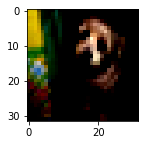

In [ ]:
# trying to view the above saved images

with open(f"perturbed_imgs_J.pkl", 'wb') as f:
  pickle.dump(L1, f)

file = open('perturbed_imgs_J.pkl', 'rb')
images_J = pickle.load(file)
file.close()


with open(f"labels_trial_J.pkl", 'wb') as f:
  pickle.dump(L2, f)

file = open('labels_trial_J.pkl', 'rb')
labels_J = pickle.load(file)


grid = torchvision.utils.make_grid(images_J[6]).cpu()
plt.figure(figsize = (2,4))
plt.imshow(np.transpose(torchvision.utils.make_grid(grid.to(device)[:128], padding=2, normalize=True).cpu(),(1,2,0)))

# Image Saving and Dataloader


In [ ]:
# to store and read back in the adversarial examples and labels

import pickle

with open(f"perturbed_imgs_trial2.pkl", 'wb') as f:
  pickle.dump(perturbed_list, f)

file = open('perturbed_imgs_trial2.pkl', 'rb')
images = pickle.load(file)
file.close()


with open(f"labels_trial2.pkl", 'wb') as f:
  pickle.dump(label_list, f)

file = open('labels_trial2.pkl', 'rb')
labels = pickle.load(file)
file.close()

In [ ]:
grid = torchvision.utils.make_grid(images[0]).cpu()
plt.figure(figsize = (2,4))
plt.imshow(np.transpose(torchvision.utils.make_grid(grid.to(device)[:128], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
# To create the dataset

class CustomImageDataset(Dataset):
    def __init__(self, labels, images, transform=None, target_transform=None):
        self.labels = labels
        self.images = images
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        image = self.images[idx]
        return image, label

In [ ]:
# to use the dataset as dataloader

trial_ds = CustomImageDataset(labels, images)
trial_loader = torch.utils.data.DataLoader(trial_ds, batch_size = 1, shuffle = True)

ValueError: ignored

In [ ]:
# Checking that the dataloader works 

def testClean2(test_loader, model):
  model.eval()
  correct_count = 0
  total_count = 0
  for data in test_loader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    #print("image size:", images.size())
    images = torch.squeeze(images) # This code is identical to testClean except for the squeeze (an extra dimension was added during the list process)
    #print("image after squeeze:", images.size())
    #print("labels: ", labels.size())
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total_count += labels.size(0)
    correct_count += (predicted == labels).sum().item()

  acc = float(correct_count/total_count)

  print("Accuracy on test set is {}".format(acc))
  return acc

# testClean2(trial_loader, inception_v3_mod)

# Adversarial Training


In [ ]:
## Training VGG on the adversarial images

#Import one of the adversarial example sets
os.chdir('/content/drive/MyDrive/Final Project/Adversarial Examples')

import pickle

file = open('perturbed_imgs_combo_0.pkl', 'rb')
perturbed_imgs_combo_0 = pickle.load(file)
file.close()


file = open('labels_combo_0.pkl', 'rb')
labels_combo_0 = pickle.load(file)
file.close()

In [ ]:
for i in range(6):
  file = open(f"perturbed_imgs_combo_{i}.pkl", 'rb')
  perturbed_imgs_combo_0 = pickle.load(file)
  file.close()


  file = open(f"labels_combo_{i}.pkl", 'rb')
  labels_combo_0 = pickle.load(file)
  file.close()

In [ ]:
#Create the dataset

ds_combo_0 = CustomImageDataset(labels_combo_0, perturbed_imgs_combo_0)
train_size = int(0.8 * len(ds_combo_0))
test_size = len(ds_combo_0) - train_size
train_dataset_0, test_dataset_0 = torch.utils.data.random_split(ds_combo_0, [train_size, test_size])

train_loader_combo_0 = torch.utils.data.DataLoader(train_dataset_0, batch_size = 1, shuffle = True)
test_loader_combo_0 = torch.utils.data.DataLoader(test_dataset_0, batch_size = 1, shuffle = True)

In [ ]:
# Testing performance of pretrained VGG on adversarial images from combo 0

testClean2(test_loader_combo_0, vgg16_bn_mod)

Accuracy on test set is 48.97


48.97

In [ ]:
# accuracy of traditional AT
os.chdir('/content/drive/MyDrive/Final Project/models')

vgg11_adv = vgg11_bn()
vgg11_adv.load_state_dict(torch.load('vgg11_adv.pt'))
vgg11_adv.to(device)

os.chdir('/content/drive/MyDrive/Final Project/models/state_dicts')
vgg11_ens_adv_indv = vgg11_bn()
vgg11_ens_adv_indv.load_state_dict(torch.load('vgg11_adv_ens_3indiv.pt'))
vgg11_ens_adv_indv.to(device)
# clean images
testClean2(test_cifar_loader, vgg11_adv)

# combo 0
testClean2(test_loader_combo_0, vgg11_adv)

os.chdir('/content/drive/MyDrive/Final Project')


NameError: ignored

In [ ]:
vgg11_adv = vgg11_bn()
#vgg11_adv.load_state_dict(torch.load('vgg11_adv.pt'))
vgg11_adv.to(device)

testClean2(test_loader_combo_0, vgg16_bn_mod)

Accuracy on test set is 48.8


48.8

In [ ]:
### Take two with different batch sizes

#Create the dataset

ds_combo_0 = CustomImageDataset(labels_combo_0, perturbed_imgs_combo_0)

train_size = int(0.8 * len(ds_combo_0))
test_size = len(ds_combo_0) - train_size
train_dataset_0, test_dataset_0 = torch.utils.data.random_split(ds_combo_0, [train_size, test_size])

train_loader_combo_0 = torch.utils.data.DataLoader(train_dataset_0, batch_size = 1, shuffle = True)
test_loader_combo_0 = torch.utils.data.DataLoader(test_dataset_0, batch_size = 1, shuffle = True)

In [ ]:
# Testing performance of adversarially trained VGG on adversarial images from combo 0

testClean2(test_loader_combo_0, model_adv2)

# Black Box Attacks


In [ ]:
# WHITE BOX ATTTACK STEP-LL METHOD 

import numpy as np

def optimize_linear(grad, eps, ord=np.inf):
  red_ind = list(range(1, len(grad.size())))
  avoid_zero_div = torch.tensor(1e-12, dtype=grad.dtype, device=grad.device)
  if ord == np.inf:
    optimal_perturbation = torch.sign(grad)
  elif ord == 1:
    abs_grad = torch.abs(grad)
    sign = torch.sign(grad)
    red_ind = list(range(1, len(grad.size())))
    abs_grad = torch.abs(grad)
    ori_shape = [1]*len(grad.size())
    ori_shape[0] = grad.size(0)

    max_abs_grad, _ = torch.max(abs_grad.view(grad.size(0), -1), 1)
    max_mask = abs_grad.eq(max_abs_grad.view(ori_shape)).to(torch.float)
    num_ties = max_mask
    for red_scalar in red_ind:
      num_ties = torch.sum(num_ties, red_scalar, keepdim=True)
    optimal_perturbation = sign * max_mask / num_ties
    opt_pert_norm = optimal_perturbation.abs().sum(dim=red_ind)
    assert torch.all(opt_pert_norm == torch.ones_like(opt_pert_norm))
  elif ord == 2:
    square = torch.max(
        avoid_zero_div,
        torch.sum(grad ** 2, red_ind, keepdim=True)
        )
    optimal_perturbation = grad / torch.sqrt(square)
    opt_pert_norm = optimal_perturbation.pow(2).sum(dim=red_ind, keepdim=True).sqrt()
    one_mask = (square <= avoid_zero_div).to(torch.float) * opt_pert_norm + \
            (square > avoid_zero_div).to(torch.float)
    assert torch.allclose(opt_pert_norm, one_mask, rtol=1e-05, atol=1e-08)

  scaled_perturbation = eps * optimal_perturbation
  return scaled_perturbation

def least_likely_class_method(model_fn, x, eps, ord = np.inf,
                         clip_min=None, clip_max=None, sanity_checks=False):
    asserts = []
    if clip_min is not None:
      assert_ge = torch.all(torch.ge(x, torch.tensor(clip_min, device=x.device, dtype=x.dtype)))
      asserts.append(assert_ge)
    if clip_max is not None:
      assert_le = torch.all(torch.le(x, torch.tensor(clip_max, device=x.device, dtype=x.dtype)))
      asserts.append(assert_le)
    x = x.clone().detach().to(torch.float).requires_grad_(True)
     
    _, y_ll = torch.min(model_fn(x), 1)
    loss_fn = torch.nn.CrossEntropyLoss()
    loss = loss_fn(model_fn(x), y_ll)
    loss = -loss
    model_fn.zero_grad()
    loss.backward()
    optimal_perturbation = optimize_linear(x.grad, eps, ord)
    adv_x = x + optimal_perturbation
    adv_x = torch.clamp(adv_x, clip_min, clip_max)
    return adv_x

In [ ]:
!pip install ipdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 793 kB 41.7 MB/s 
     |████████████████████████████████| 1.6 MB 58.4 MB/s 
  Created wheel for ipdb: filename=ipdb-0.13.9-py3-none-any.whl size=11649 sha256=102da1efad75d8ef384f944a1ee462df3b32b0255aa4969522a1d101cdcbbd11
  Stored in directory: /root/.cache/pip/wheels/65/cd/cc/aaf92acae337a28fdd2aa4d632196a59745c8c39f76eaeed01
Successfully built ipdb
  Attempting uninstall: ipython
    Found existing installation: ipython 7.9.0
    Uninstalling ipython-7.9.0:
      Successfully uninstalled ipython-7.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython~=7.9.0, but you have ipython 7.34.0 which is incompatible.


In [ ]:
# BOUNDARY BLACK BOX ATTACK
import numpy as np
import time
import os
from PIL import Image
from torchvision import models, transforms, datasets
#from resnet import *

def orthogonal_perturbation(delta, prev_sample, target_sample):
	perturb = np.random.randn(1, 3, 32, 32)
	perturb /= np.linalg.norm(perturb, axis=(2, 3))
	perturb *= delta * np.mean(get_diff(target_sample, prev_sample))

	diff = (target_sample - prev_sample).astype(np.float32) 
	diff /= get_diff(target_sample, prev_sample)
	perturb -= (np.vdot(perturb, diff) / np.linalg.norm(diff)**2) * diff

	overflow = (prev_sample + perturb) - 1
	perturb -= overflow * (overflow > 0)
	underflow = -(prev_sample + perturb)
	perturb += underflow * (underflow > 0)
	return perturb


def forward_perturbation(epsilon, prev_sample, target_sample):
	perturb = target_sample - prev_sample
	perturb *= epsilon
	return perturb


def get_diff(sample_1, sample_2):
	return np.linalg.norm(sample_1 - sample_2, axis=(2, 3))


def boundary_attack(classifier, initial_sample, target_sample, attack_class, target_class):
    adversarial_sample = initial_sample
    n_steps = 0
    n_calls = 0
    epsilon = 1.
    delta = 0.1

    while True:
        trial_sample = adversarial_sample + forward_perturbation(epsilon, adversarial_sample, target_sample)
        prediction = classifier(trial_sample)
        n_calls += 1
        if torch.argmax(prediction) == attack_class:
            adversarial_sample = trial_sample
            break
        else:
            epsilon *= 0.9

    # Iteratively run attack
    while True:
        print("Step #{}...".format(n_steps))
        print("\tDelta step...")
        d_step = 0
        while True:
            d_step += 1
            print("\t#{}".format(d_step))
            trial_samples = []
            for i in np.arange(10):
                trial_sample = adversarial_sample + orthogonal_perturbation(delta, adversarial_sample, target_sample)
                trial_samples.append(trial_sample)

            predictions = classifier(trial_samples)
            n_calls += 10
            predictions = np.argmax(predictions, axis=1)
            d_score = np.mean(predictions == attack_class)
            if d_score > 0.0:
                if d_score < 0.3:
                    delta *= 0.9
                elif d_score > 0.7:
                    delta /= 0.9
                adversarial_sample = np.array(trial_samples)[np.where(predictions == attack_class)[0][0]]
                break
            else:
                delta *= 0.9
        # Forward step
        print("\tEpsilon step...")
        e_step = 0
        while True:
            e_step += 1
            print("\t#{}".format(e_step))
            trial_sample = adversarial_sample + forward_perturbation(epsilon, adversarial_sample, target_sample)

            prediction = classifier(trial_sample)
            n_calls += 1
            if np.argmax(prediction) == attack_class:
                adversarial_sample = trial_sample
                epsilon /= 0.5
                break
            elif e_step > 500:
                    break
            else:
                epsilon *= 0.5

        n_steps += 1
        chkpts = [1, 5, 10, 50, 100, 500]
        if (n_steps in chkpts) or (n_steps % 500 == 0):
            print("{} steps".format(n_steps))
        diff = np.mean(get_diff(adversarial_sample, target_sample))
        if diff <= 1e-3 or e_step > 500:
            print("{} steps".format(n_steps))
            print("Mean Squared Error: {}".format(diff))
            break

        print("Mean Squared Error: {}".format(diff))
        print("Calls: {}".format(n_calls))
        print("Attack Class: {}".format(attack_class))
        print("Target Class: {}".format(target_class))
        print("Adversarial Class: {}".format(np.argmax(prediction)))


if __name__ == "__main__":

    classifier = resnet18_mod

    initial_sample, attack_class = next(iter(test_cifar_loader))

    target_sample, target_class = next(iter(test_cifar_loader))
    # while (attack_class == target_class):
    #     target_sample, target_class = next(iter(test_cifar_loader))

    # folder = time.strftime('%Y%m%d_%H%M%S', time.localtime())
    # os.mkdir(os.path.join("image", folder))

    boundary_attack(classifier, initial_sample, target_sample, attack_class, target_class)

RuntimeError: ignored

In [ ]:
#TRANSFER ATTACKO ON RESNET18

import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn 
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

model = resnet18_mod

if torch.cuda.is_available():
  model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.001,momentum = 0.9,weight_decay = 0.006)

# FAST GRADIENT SIGN METHOD (FGSM)
def FGSM(test_loader,epsilon = 0.0625, min_val = -1, max_val = 1):
  correct = 0                
  adv_correct = 0
  misclassified = 0
  total = 0
  adv_noise =0 
  adverserial_images = []
  y_preds = []
  y_preds_adv = []
  test_images = []
  test_label = []
  
  for i, (images,labels) in enumerate(test_loader):
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
    images = Variable(images,requires_grad = True)
    labels = Variable(labels)
    
    outputs = model(images)
    loss =criterion(outputs,labels)

    model.zero_grad()
    if images.grad is not None:
      images.grad.data.fill_(0)
    loss.backward()
    
    grad = torch.sign(images.grad.data)
    images_adv = torch.clamp(images.data + epsilon*grad,min_val,max_val)     # x_adv = x + epsilon*grad
    
    adv_output = model(Variable(images_adv)) 
    _,predicted = torch.max(outputs.data,1)     
    _,adv_predicted = torch.max(adv_output.data,1) 
    
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    adv_correct += (adv_predicted == labels).sum().item()
    misclassified += (predicted != adv_predicted).sum().item()
    
    adverserial_images.extend((images_adv).cpu().data.numpy())
    y_preds.extend(predicted.cpu().data.numpy())
    y_preds_adv.extend(adv_predicted.cpu().data.numpy())
    test_images.extend(images.cpu().data.numpy())
    test_label.extend(labels.cpu().data.numpy())
    
    
  np.save('adverserial_images.npy',adverserial_images)    
  np.save('y_preds.npy',y_preds)
  np.save('y_preds_adv.npy',y_preds_adv)
  np.save('test_images.npy',test_images)
  np.save('test_label.npy',test_label)
  print('Accuracy of the model w/0 adverserial attack on test images is : {} %'.format(100*correct/total))
  print('Accuracy of the model with adverserial attack on test images is : {} %'.format(100* adv_correct/total))
  print('Number of misclassified examples(as compared to clean predictions): {}/{}'.format(misclassified,total))

#  ITERATIVE - FGSM
def i_FGSM(test_loader,iterations = 1,epsilon = 0.1,min_val = -1,max_val = 1):
  correct = 0              
  adv_correct = 0
  misclassified = 0
  total = 0 
  adverserial_images = []
  y_preds = []
  y_preds_adv = []
  test_images = []
  test_label = []
  
  for i, (images,labels) in enumerate(test_loader):
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
      output_clean = model(Variable(images))
    images_adv = Variable(images.data,requires_grad = True)
    for j in range(iterations):  
      if torch.cuda.is_available():
        images_adv = images_adv.cuda()
      outputs = model(images_adv)
      # outputs2 = model2(images_adv)
      # outputs3 = model3(images_adv)
      loss = criterion(outputs,Variable(labels))
      # loss2 = criterion(outputs2,Variable(labels))
      # loss3 = criterion(outputs3,Variable(labels))
      model.zero_grad()
      # model2.zero_grad()
      # model3.zero_grad()
      if images_adv.grad is not None:
        images.adv.grad.data.fill_(0)
      loss.backward()
      grad = torch.sign(images_adv.grad.data)  
      images_adv = images_adv + (epsilon/iterations)*grad  

      images_adv = torch.where(images_adv > images + epsilon,images+epsilon,images_adv)
      images_adv = torch.where(images_adv < images-epsilon,images-epsilon,images_adv)
      images_adv = torch.clamp(images_adv,min_val,max_val)
      images_adv = Variable(images_adv.data,requires_grad = True)
      
    adv_output = model(Variable(images_adv))
    
    _,predicted = torch.max(output_clean.data,1)    
    _,adv_predicted = torch.max(adv_output.data,1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    adv_correct += (adv_predicted == labels).sum().item()
    misclassified += (predicted != adv_predicted).sum().item()
    
    adverserial_images.extend((images_adv).cpu().data.numpy())
    y_preds.extend(predicted.cpu().data.numpy())
    y_preds_adv.extend(adv_predicted.cpu().data.numpy())
    test_images.extend(images.cpu().data.numpy())
    test_label.extend(labels.cpu().data.numpy())
    
  np.save('adverserial_images.npy',adverserial_images)
  np.save('y_preds.npy',y_preds)
  np.save('y_preds_adv.npy',y_preds_adv)
  np.save('test_images.npy',test_images)
  np.save('test_label.npy',test_label)
  print('Accuracy of the model w/0 adverserial attack on test images is : {} %'.format(100*correct/total))
  print('Accuracy of the model with adverserial attack on test images is : {} %'.format(100* adv_correct/total))
  print('Number of misclassified examples(as compared to clean predictions): {}/{}'.format(misclassified,total))


i_FGSM(test_cifar_loader, iterations = 15,epsilon = 0.015625, min_val = -1,max_val = 1) 
FGSM(test_cifar_loader, epsilon = 0.015625, min_val = -1, max_val = 1)

Accuracy of the model w/0 adverserial attack on test images is : 38.72 %
Accuracy of the model with adverserial attack on test images is : 0.26 %
Number of misclassified examples(as compared to clean predictions): 4007/10000
Accuracy of the model w/0 adverserial attack on test images is : 38.72 %
Accuracy of the model with adverserial attack on test images is : 5.33 %
Number of misclassified examples(as compared to clean predictions): 4008/10000


In [ ]:
# TRANSFER ATACK ON MOBILENETV2MOD

import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn 
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms


model = mobilenet_v2_mod


if torch.cuda.is_available():
  model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.001,momentum = 0.9,weight_decay = 0.006)

# FAST GRADIENT SIGN METHOD (FGSM)
def FGSM(test_loader,epsilon = 0.0625, min_val = -1, max_val = 1):
  correct = 0                
  adv_correct = 0
  misclassified = 0
  total = 0
  adv_noise =0 
  adverserial_images = []
  y_preds = []
  y_preds_adv = []
  test_images = []
  test_label = []
  
  for i, (images,labels) in enumerate(test_loader):
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
    images = Variable(images,requires_grad = True)
    labels = Variable(labels)
    
    outputs = model(images)
    loss =criterion(outputs,labels)

    model.zero_grad()
    if images.grad is not None:
      images.grad.data.fill_(0)
    loss.backward()
    
    grad = torch.sign(images.grad.data)
    images_adv = torch.clamp(images.data + epsilon*grad,min_val,max_val)     # x_adv = x + epsilon*grad
    
    adv_output = model(Variable(images_adv))  
    _,predicted = torch.max(outputs.data,1)     
    _,adv_predicted = torch.max(adv_output.data,1) 
    
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    adv_correct += (adv_predicted == labels).sum().item()
    misclassified += (predicted != adv_predicted).sum().item()
    
    adverserial_images.extend((images_adv).cpu().data.numpy())
    y_preds.extend(predicted.cpu().data.numpy())
    y_preds_adv.extend(adv_predicted.cpu().data.numpy())
    test_images.extend(images.cpu().data.numpy())
    test_label.extend(labels.cpu().data.numpy())
    
    
  np.save('adverserial_images.npy',adverserial_images)    
  np.save('y_preds.npy',y_preds)
  np.save('y_preds_adv.npy',y_preds_adv)
  np.save('test_images.npy',test_images)
  np.save('test_label.npy',test_label)
  print('Accuracy of the model w/0 adverserial attack on test images is : {} %'.format(100*correct/total))
  print('Accuracy of the model with adverserial attack on test images is : {} %'.format(100* adv_correct/total))
  print('Number of misclassified examples(as compared to clean predictions): {}/{}'.format(misclassified,total))

#  ITERATIVE - FGSM

def i_FGSM(test_loader,iterations = 1,epsilon = 0.1,min_val = -1,max_val = 1):
  correct = 0              
  adv_correct = 0
  misclassified = 0
  total = 0 
  adverserial_images = []
  y_preds = []
  y_preds_adv = []
  test_images = []
  test_label = []
  
  for i, (images,labels) in enumerate(test_loader):
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
      output_clean = model(Variable(images))
    images_adv = Variable(images.data,requires_grad = True)
    for j in range(iterations):  
      if torch.cuda.is_available():
        images_adv = images_adv.cuda()
      outputs = model(images_adv)
      loss = criterion(outputs,Variable(labels))
      model.zero_grad()
      if images_adv.grad is not None:
        images.adv.grad.data.fill_(0)
      loss.backward()
      grad = torch.sign(images_adv.grad.data)  
      images_adv = images_adv + (epsilon/iterations)*grad  

      images_adv = torch.where(images_adv > images + epsilon,images+epsilon,images_adv)
      images_adv = torch.where(images_adv < images-epsilon,images-epsilon,images_adv)
      images_adv = torch.clamp(images_adv,min_val,max_val)
      images_adv = Variable(images_adv.data,requires_grad = True)
      
    adv_output = model(Variable(images_adv))
    _,predicted = torch.max(output_clean.data,1)     
    _,adv_predicted = torch.max(adv_output.data,1) 
    
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    adv_correct += (adv_predicted == labels).sum().item()
    misclassified += (predicted != adv_predicted).sum().item()
    
    adverserial_images.extend((images_adv).cpu().data.numpy())
    y_preds.extend(predicted.cpu().data.numpy())
    y_preds_adv.extend(adv_predicted.cpu().data.numpy())
    test_images.extend(images.cpu().data.numpy())
    test_label.extend(labels.cpu().data.numpy())
    
  np.save('adverserial_images.npy',adverserial_images)
  np.save('y_preds.npy',y_preds)
  np.save('y_preds_adv.npy',y_preds_adv)
  np.save('test_images.npy',test_images)
  np.save('test_label.npy',test_label)
  print('Accuracy of the model w/0 adverserial attack on test images is : {} %'.format(100*correct/total))
  print('Accuracy of the model with adverserial attack on test images is : {} %'.format(100* adv_correct/total))
  print('Number of misclassified examples(as compared to clean predictions): {}/{}'.format(misclassified,total))


i_FGSM(test_cifar_loader, iterations = 15,epsilon = 0.0625, min_val = -1,max_val = 1) 
FGSM(test_cifar_loader, epsilon = 0.0625, min_val = -1, max_val = 1)

Accuracy of the model w/0 adverserial attack on test images is : 46.37 %
Accuracy of the model with adverserial attack on test images is : 0.0 %
Number of misclassified examples(as compared to clean predictions): 4938/10000
Accuracy of the model w/0 adverserial attack on test images is : 46.37 %
Accuracy of the model with adverserial attack on test images is : 9.25 %
Number of misclassified examples(as compared to clean predictions): 5217/10000


In [ ]:
# TRANSFER ATTACK ON GOOGLENETMOD

import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn 
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms


model = googlenet_mod

if torch.cuda.is_available():
  model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.001,momentum = 0.9,weight_decay = 0.006)

# FAST GRADIENT SIGN METHOD (FGSM)
def FGSM(test_loader,epsilon = 0.0625, min_val = -1, max_val = 1):
  correct = 0                
  adv_correct = 0
  misclassified = 0
  total = 0
  adv_noise =0 
  adverserial_images = []
  y_preds = []
  y_preds_adv = []
  test_images = []
  test_label = []
  
  for i, (images,labels) in enumerate(test_loader):
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
    images = Variable(images,requires_grad = True)
    labels = Variable(labels)
    
    outputs = model(images)
    loss =criterion(outputs,labels)

    model.zero_grad()
    if images.grad is not None:
      images.grad.data.fill_(0)
    loss.backward()
    
    grad = torch.sign(images.grad.data)
    images_adv = torch.clamp(images.data + epsilon*grad,min_val,max_val)     # x_adv = x + epsilon*grad
    
    adv_output = model(Variable(images_adv)) 
    _,predicted = torch.max(outputs.data,1)     
    _,adv_predicted = torch.max(adv_output.data,1) 
    
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    adv_correct += (adv_predicted == labels).sum().item()
    misclassified += (predicted != adv_predicted).sum().item()
    
    adverserial_images.extend((images_adv).cpu().data.numpy())
    y_preds.extend(predicted.cpu().data.numpy())
    y_preds_adv.extend(adv_predicted.cpu().data.numpy())
    test_images.extend(images.cpu().data.numpy())
    test_label.extend(labels.cpu().data.numpy())
    
    
  np.save('adverserial_images.npy',adverserial_images)    
  np.save('y_preds.npy',y_preds)
  np.save('y_preds_adv.npy',y_preds_adv)
  np.save('test_images.npy',test_images)
  np.save('test_label.npy',test_label)
  print('Accuracy of the model w/0 adverserial attack on test images is : {} %'.format(100*correct/total))
  print('Accuracy of the model with adverserial attack on test images is : {} %'.format(100* adv_correct/total))
  print('Number of misclassified examples(as compared to clean predictions): {}/{}'.format(misclassified,total))




#  ITERATIVE - FGSM

def i_FGSM(test_loader,iterations = 1,epsilon = 0.1,min_val = -1,max_val = 1):
  correct = 0              
  adv_correct = 0
  misclassified = 0
  total = 0 
  adverserial_images = []
  y_preds = []
  y_preds_adv = []
  test_images = []
  test_label = []
  
  for i, (images,labels) in enumerate(test_loader):
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
      output_clean = model(Variable(images))
      # output_clean2 = model2(Variable(images))
      # output_clean3 = model3(Variable(images))
    images_adv = Variable(images.data,requires_grad = True)
    for j in range(iterations):  
      if torch.cuda.is_available():
        images_adv = images_adv.cuda()
      outputs = model(images_adv)
      # outputs2 = model2(images_adv)
      # outputs3 = model3(images_adv)
      loss = criterion(outputs,Variable(labels))
      # loss2 = criterion(outputs2,Variable(labels))
      # loss3 = criterion(outputs3,Variable(labels))
      model.zero_grad()
      # model2.zero_grad()
      # model3.zero_grad()
      if images_adv.grad is not None:
        images.adv.grad.data.fill_(0)
      loss.backward()
      grad = torch.sign(images_adv.grad.data)  
      images_adv = images_adv + (epsilon/iterations)*grad  

      images_adv = torch.where(images_adv > images + epsilon,images+epsilon,images_adv)
      images_adv = torch.where(images_adv < images-epsilon,images-epsilon,images_adv)
      images_adv = torch.clamp(images_adv,min_val,max_val)
      images_adv = Variable(images_adv.data,requires_grad = True)
      
    adv_output = model(Variable(images_adv))
    # adv_output2 = model2(Variable(images_adv))
    # adv_output3 = model3(Variable(images_adv))
    
    _,predicted = torch.max(output_clean.data,1)
    # _,predicted2 = torch.max(output_clean2.data,1)   
    # _,predicted3 = torch.max(output_clean3.data,1)      
    _,adv_predicted = torch.max(adv_output.data,1)
    # _,adv_predicted2 = torch.max(adv_output2.data,1) 
    # _,adv_predicted3 = torch.max(adv_output3.data,1)  
    
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    # correct2 += (predicted2 == labels).sum().item()
    # correct3 += (predicted3 == labels).sum().item()
    adv_correct += (adv_predicted == labels).sum().item()
    # adv_correct2 += (adv_predicted2 == labels).sum().item()
    # adv_correct3 += (adv_predicted3 == labels).sum().item()
    misclassified += (predicted != adv_predicted).sum().item()
    # misclassified2 += (predicted2 != adv_predicted2).sum().item()
    # misclassified3 += (predicted3 != adv_predicted3).sum().item()
    
    adverserial_images.extend((images_adv).cpu().data.numpy())
    y_preds.extend(predicted.cpu().data.numpy())
    y_preds_adv.extend(adv_predicted.cpu().data.numpy())
    test_images.extend(images.cpu().data.numpy())
    test_label.extend(labels.cpu().data.numpy())
    
  np.save('adverserial_images.npy',adverserial_images)
  np.save('y_preds.npy',y_preds)
  np.save('y_preds_adv.npy',y_preds_adv)
  np.save('test_images.npy',test_images)
  np.save('test_label.npy',test_label)
  print('Accuracy of the model w/0 adverserial attack on test images is : {} %'.format(100*correct/total))
  print('Accuracy of the model with adverserial attack on test images is : {} %'.format(100* adv_correct/total))
  print('Number of misclassified examples(as compared to clean predictions): {}/{}'.format(misclassified,total))


i_FGSM(test_cifar_loader, iterations = 15,epsilon = 0.0625, min_val = -1,max_val = 1) 
FGSM(test_cifar_loader, epsilon = 0.0625, min_val = -1, max_val = 1)

NameError: ignored

In [ ]:


# TRANSFER ATTACK ON VGG!!_ADV

import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn 
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms


model = model_adv2

if torch.cuda.is_available():
  model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.001,momentum = 0.9,weight_decay = 0.006)

# FAST GRADIENT SIGN METHOD (FGSM)
def FGSM(test_loader,epsilon = 0.0625, min_val = -1, max_val = 1):
  correct = 0                
  adv_correct = 0
  misclassified = 0
  total = 0
  adv_noise =0 
  adverserial_images = []
  y_preds = []
  y_preds_adv = []
  test_images = []
  test_label = []
  
  for i, (images,labels) in enumerate(test_loader):
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
    images = Variable(images,requires_grad = True)
    labels = Variable(labels)
    
    outputs = model(images)
    loss =criterion(outputs,labels)

    model.zero_grad()
    if images.grad is not None:
      images.grad.data.fill_(0)
    loss.backward()
    
    grad = torch.sign(images.grad.data)
    images_adv = torch.clamp(images.data + epsilon*grad,min_val,max_val)     # x_adv = x + epsilon*grad
    
    adv_output = model(Variable(images_adv)) 
    _,predicted = torch.max(outputs.data,1)     
    _,adv_predicted = torch.max(adv_output.data,1) 
    
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    adv_correct += (adv_predicted == labels).sum().item()
    misclassified += (predicted != adv_predicted).sum().item()
    
    adverserial_images.extend((images_adv).cpu().data.numpy())
    y_preds.extend(predicted.cpu().data.numpy())
    y_preds_adv.extend(adv_predicted.cpu().data.numpy())
    test_images.extend(images.cpu().data.numpy())
    test_label.extend(labels.cpu().data.numpy())
    
    
  np.save('adverserial_images.npy',adverserial_images)    
  np.save('y_preds.npy',y_preds)
  np.save('y_preds_adv.npy',y_preds_adv)
  np.save('test_images.npy',test_images)
  np.save('test_label.npy',test_label)
  print('Accuracy of the model w/0 adverserial attack on test images is : {} %'.format(100*correct/total))
  print('Accuracy of the model with adverserial attack on test images is : {} %'.format(100* adv_correct/total))
  print('Number of misclassified examples(as compared to clean predictions): {}/{}'.format(misclassified,total))




#  ITERATIVE - FGSM

def i_FGSM(test_loader,iterations = 1,epsilon = 0.1,min_val = -1,max_val = 1):
  correct = 0              
  adv_correct = 0
  misclassified = 0
  total = 0 
  adverserial_images = []
  y_preds = []
  y_preds_adv = []
  test_images = []
  test_label = []
  
  for i, (images,labels) in enumerate(test_loader):
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
      output_clean = model(Variable(images))
      # output_clean2 = model2(Variable(images))
      # output_clean3 = model3(Variable(images))
    images_adv = Variable(images.data,requires_grad = True)
    for j in range(iterations):  
      if torch.cuda.is_available():
        images_adv = images_adv.cuda()
      outputs = model(images_adv)
      # outputs2 = model2(images_adv)
      # outputs3 = model3(images_adv)
      loss = criterion(outputs,Variable(labels))
      # loss2 = criterion(outputs2,Variable(labels))
      # loss3 = criterion(outputs3,Variable(labels))
      model.zero_grad()
      # model2.zero_grad()
      # model3.zero_grad()
      if images_adv.grad is not None:
        images.adv.grad.data.fill_(0)
      loss.backward()
      grad = torch.sign(images_adv.grad.data)  
      images_adv = images_adv + (epsilon/iterations)*grad  

      images_adv = torch.where(images_adv > images + epsilon,images+epsilon,images_adv)
      images_adv = torch.where(images_adv < images-epsilon,images-epsilon,images_adv)
      images_adv = torch.clamp(images_adv,min_val,max_val)
      images_adv = Variable(images_adv.data,requires_grad = True)
      
    adv_output = model(Variable(images_adv))
    # adv_output2 = model2(Variable(images_adv))
    # adv_output3 = model3(Variable(images_adv))
    
    _,predicted = torch.max(output_clean.data,1)
    # _,predicted2 = torch.max(output_clean2.data,1)   
    # _,predicted3 = torch.max(output_clean3.data,1)      
    _,adv_predicted = torch.max(adv_output.data,1)
    # _,adv_predicted2 = torch.max(adv_output2.data,1) 
    # _,adv_predicted3 = torch.max(adv_output3.data,1)  
    
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    # correct2 += (predicted2 == labels).sum().item()
    # correct3 += (predicted3 == labels).sum().item()
    adv_correct += (adv_predicted == labels).sum().item()
    # adv_correct2 += (adv_predicted2 == labels).sum().item()
    # adv_correct3 += (adv_predicted3 == labels).sum().item()
    misclassified += (predicted != adv_predicted).sum().item()
    # misclassified2 += (predicted2 != adv_predicted2).sum().item()
    # misclassified3 += (predicted3 != adv_predicted3).sum().item()
    
    adverserial_images.extend((images_adv).cpu().data.numpy())
    y_preds.extend(predicted.cpu().data.numpy())
    y_preds_adv.extend(adv_predicted.cpu().data.numpy())
    test_images.extend(images.cpu().data.numpy())
    test_label.extend(labels.cpu().data.numpy())
    
  np.save('adverserial_images.npy',adverserial_images)
  np.save('y_preds.npy',y_preds)
  np.save('y_preds_adv.npy',y_preds_adv)
  np.save('test_images.npy',test_images)
  np.save('test_label.npy',test_label)
  print('Accuracy of the model w/0 adverserial attack on test images is : {} %'.format(100*correct/total))
  print('Accuracy of the model with adverserial attack on test images is : {} %'.format(100* adv_correct/total))
  print('Number of misclassified examples(as compared to clean predictions): {}/{}'.format(misclassified,total))


i_FGSM(test_cifar_loader, iterations = 15,epsilon = 0.015625, min_val = -1,max_val = 1) 
FGSM(test_cifar_loader, epsilon = 0.015625, min_val = -1, max_val = 1)

Accuracy of the model w/0 adverserial attack on test images is : 94.0 %
Accuracy of the model with adverserial attack on test images is : 39.53 %
Number of misclassified examples(as compared to clean predictions): 5478/10000
Accuracy of the model w/0 adverserial attack on test images is : 94.0 %
Accuracy of the model with adverserial attack on test images is : 59.15 %
Number of misclassified examples(as compared to clean predictions): 3525/10000


In [ ]:
from vgg import vgg11_bn
vgg11 = vgg11_bn(pretrained=True).to(device)


In [ ]:


# TRANSFER ATTACK ON VGG!!_ADV

import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn 
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms


model = vgg11_adv

if torch.cuda.is_available():
  model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.001,momentum = 0.9,weight_decay = 0.006)

# FAST GRADIENT SIGN METHOD (FGSM)
def FGSM(test_loader,epsilon = 0.0625, min_val = -1, max_val = 1):
  correct = 0                
  adv_correct = 0
  misclassified = 0
  total = 0
  adv_noise =0 
  adverserial_images = []
  y_preds = []
  y_preds_adv = []
  test_images = []
  test_label = []
  
  for i, (images,labels) in enumerate(test_loader):
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
    images = Variable(images,requires_grad = True)
    labels = Variable(labels)
    
    outputs = resnet18_mod(images)
    loss =criterion(outputs,labels)

    model.zero_grad()
    if images.grad is not None:
      images.grad.data.fill_(0)
    loss.backward()
    
    grad = torch.sign(images.grad.data)
    images_adv = torch.clamp(images.data + epsilon*grad,min_val,max_val)     # x_adv = x + epsilon*grad
    
    adv_output = model(Variable(images_adv)) 
    _,predicted = torch.max(outputs.data,1)     
    _,adv_predicted = torch.max(adv_output.data,1) 
    
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    adv_correct += (adv_predicted == labels).sum().item()
    misclassified += (predicted != adv_predicted).sum().item()
    
    adverserial_images.extend((images_adv).cpu().data.numpy())
    y_preds.extend(predicted.cpu().data.numpy())
    y_preds_adv.extend(adv_predicted.cpu().data.numpy())
    test_images.extend(images.cpu().data.numpy())
    test_label.extend(labels.cpu().data.numpy())
    
    
  np.save('adverserial_images.npy',adverserial_images)    
  np.save('y_preds.npy',y_preds)
  np.save('y_preds_adv.npy',y_preds_adv)
  np.save('test_images.npy',test_images)
  np.save('test_label.npy',test_label)
  print('Accuracy of the model w/0 adverserial attack on test images is : {} %'.format(100*correct/total))
  print('Accuracy of the model with adverserial attack on test images is : {} %'.format(100* adv_correct/total))
  print('Number of misclassified examples(as compared to clean predictions): {}/{}'.format(misclassified,total))




#  ITERATIVE - FGSM

def i_FGSM(test_loader,iterations = 1,epsilon = 0.1,min_val = -1,max_val = 1):
  correct = 0              
  adv_correct = 0
  misclassified = 0
  total = 0 
  adverserial_images = []
  y_preds = []
  y_preds_adv = []
  test_images = []
  test_label = []
  
  for i, (images,labels) in enumerate(test_loader):
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
      output_clean = model(Variable(images))
      # output_clean2 = model2(Variable(images))
      # output_clean3 = model3(Variable(images))
    images_adv = Variable(images.data,requires_grad = True)
    for j in range(iterations):  
      if torch.cuda.is_available():
        images_adv = images_adv.cuda()
      outputs = resnet18_mod(images_adv)
      # outputs2 = model2(images_adv)
      # outputs3 = model3(images_adv)
      loss = criterion(outputs,Variable(labels))
      # loss2 = criterion(outputs2,Variable(labels))
      # loss3 = criterion(outputs3,Variable(labels))
      model.zero_grad()
      # model2.zero_grad()
      # model3.zero_grad()
      if images_adv.grad is not None:
        images.adv.grad.data.fill_(0)
      loss.backward()
      grad = torch.sign(images_adv.grad.data)  
      images_adv = images_adv + (epsilon/iterations)*grad  

      images_adv = torch.where(images_adv > images + epsilon,images+epsilon,images_adv)
      images_adv = torch.where(images_adv < images-epsilon,images-epsilon,images_adv)
      images_adv = torch.clamp(images_adv,min_val,max_val)
      images_adv = Variable(images_adv.data,requires_grad = True)
      
    adv_output = model(Variable(images_adv))
    # adv_output2 = model2(Variable(images_adv))
    # adv_output3 = model3(Variable(images_adv))
    
    _,predicted = torch.max(output_clean.data,1)
    # _,predicted2 = torch.max(output_clean2.data,1)   
    # _,predicted3 = torch.max(output_clean3.data,1)      
    _,adv_predicted = torch.max(adv_output.data,1)
    # _,adv_predicted2 = torch.max(adv_output2.data,1) 
    # _,adv_predicted3 = torch.max(adv_output3.data,1)  
    
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    # correct2 += (predicted2 == labels).sum().item()
    # correct3 += (predicted3 == labels).sum().item()
    adv_correct += (adv_predicted == labels).sum().item()
    # adv_correct2 += (adv_predicted2 == labels).sum().item()
    # adv_correct3 += (adv_predicted3 == labels).sum().item()
    misclassified += (predicted != adv_predicted).sum().item()
    # misclassified2 += (predicted2 != adv_predicted2).sum().item()
    # misclassified3 += (predicted3 != adv_predicted3).sum().item()
    
    adverserial_images.extend((images_adv).cpu().data.numpy())
    y_preds.extend(predicted.cpu().data.numpy())
    y_preds_adv.extend(adv_predicted.cpu().data.numpy())
    test_images.extend(images.cpu().data.numpy())
    test_label.extend(labels.cpu().data.numpy())
    
  np.save('adverserial_images.npy',adverserial_images)
  np.save('y_preds.npy',y_preds)
  np.save('y_preds_adv.npy',y_preds_adv)
  np.save('test_images.npy',test_images)
  np.save('test_label.npy',test_label)
  print('Accuracy of the model w/0 adverserial attack on test images is : {} %'.format(100*correct/total))
  print('Accuracy of the model with adverserial attack on test images is : {} %'.format(100* adv_correct/total))
  print('Number of misclassified examples(as compared to clean predictions): {}/{}'.format(misclassified,total))


#i_FGSM(test_cifar_loader, iterations = 15,epsilon = 0.015625, min_val = -2.11,max_val = 2.11) 
FGSM(test_cifar_loader, epsilon = 0.015625, min_val = -2.11, max_val = 2.11)

Accuracy of the model w/0 adverserial attack on test images is : 38.72 %
Accuracy of the model with adverserial attack on test images is : 68.89 %
Number of misclassified examples(as compared to clean predictions): 6623/10000


In [ ]:


# TRANSFER ATTACK ON VGG11 PRE-TRAINED ONLY ON CLEAN DATA

import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn 
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms


model = vgg11

if torch.cuda.is_available():
  model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.001,momentum = 0.9,weight_decay = 0.006)

# FAST GRADIENT SIGN METHOD (FGSM)
def FGSM(test_loader,epsilon = 0.0625, min_val = -1, max_val = 1):
  correct = 0                
  adv_correct = 0
  misclassified = 0
  total = 0
  adv_noise =0 
  adverserial_images = []
  y_preds = []
  y_preds_adv = []
  test_images = []
  test_label = []
  
  for i, (images,labels) in enumerate(test_loader):
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
    images = Variable(images,requires_grad = True)
    labels = Variable(labels)
    
    outputs = mobilenet_v2_mod(images)
    loss =criterion(outputs,labels)

    model.zero_grad()
    if images.grad is not None:
      images.grad.data.fill_(0)
    loss.backward()
    
    grad = torch.sign(images.grad.data)
    images_adv = torch.clamp(images.data + epsilon*grad,min_val,max_val)     # x_adv = x + epsilon*grad
    
    adv_output = model(Variable(images_adv)) 
    _,predicted = torch.max(outputs.data,1)     
    _,adv_predicted = torch.max(adv_output.data,1) 
    
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    adv_correct += (adv_predicted == labels).sum().item()
    misclassified += (predicted != adv_predicted).sum().item()
    
    adverserial_images.extend((images_adv).cpu().data.numpy())
    y_preds.extend(predicted.cpu().data.numpy())
    y_preds_adv.extend(adv_predicted.cpu().data.numpy())
    test_images.extend(images.cpu().data.numpy())
    test_label.extend(labels.cpu().data.numpy())
    
    
  np.save('adverserial_images.npy',adverserial_images)    
  np.save('y_preds.npy',y_preds)
  np.save('y_preds_adv.npy',y_preds_adv)
  np.save('test_images.npy',test_images)
  np.save('test_label.npy',test_label)
  print('Accuracy of the model w/0 adverserial attack on test images is : {} %'.format(100*correct/total))
  print('Accuracy of the model with adverserial attack on test images is : {} %'.format(100* adv_correct/total))
  print('Number of misclassified examples(as compared to clean predictions): {}/{}'.format(misclassified,total))




#  ITERATIVE - FGSM

def i_FGSM(test_loader,iterations = 1,epsilon = 0.1,min_val = -1,max_val = 1):
  correct = 0              
  adv_correct = 0
  misclassified = 0
  total = 0 
  adverserial_images = []
  y_preds = []
  y_preds_adv = []
  test_images = []
  test_label = []
  
  for i, (images,labels) in enumerate(test_loader):
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
      output_clean = model(Variable(images))
      # output_clean2 = model2(Variable(images))
      # output_clean3 = model3(Variable(images))
    images_adv = Variable(images.data,requires_grad = True)
    for j in range(iterations):  
      if torch.cuda.is_available():
        images_adv = images_adv.cuda()
      outputs = model(images_adv)
      # outputs2 = model2(images_adv)
      # outputs3 = model3(images_adv)
      loss = criterion(outputs,Variable(labels))
      # loss2 = criterion(outputs2,Variable(labels))
      # loss3 = criterion(outputs3,Variable(labels))
      model.zero_grad()
      # model2.zero_grad()
      # model3.zero_grad()
      if images_adv.grad is not None:
        images.adv.grad.data.fill_(0)
      loss.backward()
      grad = torch.sign(images_adv.grad.data)  
      images_adv = images_adv + (epsilon/iterations)*grad  

      images_adv = torch.where(images_adv > images + epsilon,images+epsilon,images_adv)
      images_adv = torch.where(images_adv < images-epsilon,images-epsilon,images_adv)
      images_adv = torch.clamp(images_adv,min_val,max_val)
      images_adv = Variable(images_adv.data,requires_grad = True)
      
    adv_output = model(Variable(images_adv))
    # adv_output2 = model2(Variable(images_adv))
    # adv_output3 = model3(Variable(images_adv))
    
    _,predicted = torch.max(output_clean.data,1)
    # _,predicted2 = torch.max(output_clean2.data,1)   
    # _,predicted3 = torch.max(output_clean3.data,1)      
    _,adv_predicted = torch.max(adv_output.data,1)
    # _,adv_predicted2 = torch.max(adv_output2.data,1) 
    # _,adv_predicted3 = torch.max(adv_output3.data,1)  
    
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    # correct2 += (predicted2 == labels).sum().item()
    # correct3 += (predicted3 == labels).sum().item()
    adv_correct += (adv_predicted == labels).sum().item()
    # adv_correct2 += (adv_predicted2 == labels).sum().item()
    # adv_correct3 += (adv_predicted3 == labels).sum().item()
    misclassified += (predicted != adv_predicted).sum().item()
    # misclassified2 += (predicted2 != adv_predicted2).sum().item()
    # misclassified3 += (predicted3 != adv_predicted3).sum().item()
    
    adverserial_images.extend((images_adv).cpu().data.numpy())
    y_preds.extend(predicted.cpu().data.numpy())
    y_preds_adv.extend(adv_predicted.cpu().data.numpy())
    test_images.extend(images.cpu().data.numpy())
    test_label.extend(labels.cpu().data.numpy())
    
  np.save('adverserial_images.npy',adverserial_images)
  np.save('y_preds.npy',y_preds)
  np.save('y_preds_adv.npy',y_preds_adv)
  np.save('test_images.npy',test_images)
  np.save('test_label.npy',test_label)
  print('Accuracy of the model w/0 adverserial attack on test images is : {} %'.format(100*correct/total))
  print('Accuracy of the model with adverserial attack on test images is : {} %'.format(100* adv_correct/total))
  print('Number of misclassified examples(as compared to clean predictions): {}/{}'.format(misclassified,total))


# i_FGSM(test_cifar_loader, iterations = 15,epsilon = 0.0625, min_val = -1,max_val = 1) 
# FGSM(test_cifar_loader, epsilon = 0.0625, min_val = -1, max_val = 1)

FGSM(test_cifar_loader, epsilon = 0.015625, min_val = -2.11, max_val = 2.11)

Accuracy of the model w/0 adverserial attack on test images is : 46.37 %
Accuracy of the model with adverserial attack on test images is : 85.18 %
Number of misclassified examples(as compared to clean predictions): 5520/10000


In [ ]:


# TRANSFER ATTACK ON VGG11 PRE-TRAINED ONLY ON CLEAN DATA

import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn 
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms


model = vgg11

if torch.cuda.is_available():
  model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.001,momentum = 0.9,weight_decay = 0.006)

# FAST GRADIENT SIGN METHOD (FGSM)
def FGSM(test_loader,epsilon = 0.0625, min_val = -1, max_val = 1):
  correct = 0                
  adv_correct = 0
  misclassified = 0
  total = 0
  adv_noise =0 
  adverserial_images = []
  y_preds = []
  y_preds_adv = []
  test_images = []
  test_label = []
  
  for i, (images,labels) in enumerate(test_loader):
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
    images = Variable(images,requires_grad = True)
    labels = Variable(labels)
    
    outputs = resnet18_mod(images)
    loss =criterion(outputs,labels)

    model.zero_grad()
    if images.grad is not None:
      images.grad.data.fill_(0)
    loss.backward()
    
    grad = torch.sign(images.grad.data)
    images_adv = torch.clamp(images.data + epsilon*grad,min_val,max_val)     # x_adv = x + epsilon*grad
    
    adv_output = model(Variable(images_adv)) 
    _,predicted = torch.max(outputs.data,1)     
    _,adv_predicted = torch.max(adv_output.data,1) 
    
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    adv_correct += (adv_predicted == labels).sum().item()
    misclassified += (predicted != adv_predicted).sum().item()
    
    adverserial_images.extend((images_adv).cpu().data.numpy())
    y_preds.extend(predicted.cpu().data.numpy())
    y_preds_adv.extend(adv_predicted.cpu().data.numpy())
    test_images.extend(images.cpu().data.numpy())
    test_label.extend(labels.cpu().data.numpy())
    
    
  np.save('adverserial_images.npy',adverserial_images)    
  np.save('y_preds.npy',y_preds)
  np.save('y_preds_adv.npy',y_preds_adv)
  np.save('test_images.npy',test_images)
  np.save('test_label.npy',test_label)
  print('Accuracy of the model w/0 adverserial attack on test images is : {} %'.format(100*correct/total))
  print('Accuracy of the model with adverserial attack on test images is : {} %'.format(100* adv_correct/total))
  print('Number of misclassified examples(as compared to clean predictions): {}/{}'.format(misclassified,total))




#  ITERATIVE - FGSM

def i_FGSM(test_loader,iterations = 1,epsilon = 0.1,min_val = -1,max_val = 1):
  correct = 0              
  adv_correct = 0
  misclassified = 0
  total = 0 
  adverserial_images = []
  y_preds = []
  y_preds_adv = []
  test_images = []
  test_label = []
  
  for i, (images,labels) in enumerate(test_loader):
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
      output_clean = model(Variable(images))
      # output_clean2 = model2(Variable(images))
      # output_clean3 = model3(Variable(images))
    images_adv = Variable(images.data,requires_grad = True)
    for j in range(iterations):  
      if torch.cuda.is_available():
        images_adv = images_adv.cuda()
      outputs = model(images_adv)
      # outputs2 = model2(images_adv)
      # outputs3 = model3(images_adv)
      loss = criterion(outputs,Variable(labels))
      # loss2 = criterion(outputs2,Variable(labels))
      # loss3 = criterion(outputs3,Variable(labels))
      model.zero_grad()
      # model2.zero_grad()
      # model3.zero_grad()
      if images_adv.grad is not None:
        images.adv.grad.data.fill_(0)
      loss.backward()
      grad = torch.sign(images_adv.grad.data)  
      images_adv = images_adv + (epsilon/iterations)*grad  

      images_adv = torch.where(images_adv > images + epsilon,images+epsilon,images_adv)
      images_adv = torch.where(images_adv < images-epsilon,images-epsilon,images_adv)
      images_adv = torch.clamp(images_adv,min_val,max_val)
      images_adv = Variable(images_adv.data,requires_grad = True)
      
    adv_output = model(Variable(images_adv))
    # adv_output2 = model2(Variable(images_adv))
    # adv_output3 = model3(Variable(images_adv))
    
    _,predicted = torch.max(output_clean.data,1)
    # _,predicted2 = torch.max(output_clean2.data,1)   
    # _,predicted3 = torch.max(output_clean3.data,1)      
    _,adv_predicted = torch.max(adv_output.data,1)
    # _,adv_predicted2 = torch.max(adv_output2.data,1) 
    # _,adv_predicted3 = torch.max(adv_output3.data,1)  
    
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    # correct2 += (predicted2 == labels).sum().item()
    # correct3 += (predicted3 == labels).sum().item()
    adv_correct += (adv_predicted == labels).sum().item()
    # adv_correct2 += (adv_predicted2 == labels).sum().item()
    # adv_correct3 += (adv_predicted3 == labels).sum().item()
    misclassified += (predicted != adv_predicted).sum().item()
    # misclassified2 += (predicted2 != adv_predicted2).sum().item()
    # misclassified3 += (predicted3 != adv_predicted3).sum().item()
    
    adverserial_images.extend((images_adv).cpu().data.numpy())
    y_preds.extend(predicted.cpu().data.numpy())
    y_preds_adv.extend(adv_predicted.cpu().data.numpy())
    test_images.extend(images.cpu().data.numpy())
    test_label.extend(labels.cpu().data.numpy())
    
  np.save('adverserial_images.npy',adverserial_images)
  np.save('y_preds.npy',y_preds)
  np.save('y_preds_adv.npy',y_preds_adv)
  np.save('test_images.npy',test_images)
  np.save('test_label.npy',test_label)
  print('Accuracy of the model w/0 adverserial attack on test images is : {} %'.format(100*correct/total))
  print('Accuracy of the model with adverserial attack on test images is : {} %'.format(100* adv_correct/total))
  print('Number of misclassified examples(as compared to clean predictions): {}/{}'.format(misclassified,total))


# i_FGSM(test_cifar_loader, iterations = 15,epsilon = 0.0625, min_val = -1,max_val = 1) 
# FGSM(test_cifar_loader, epsilon = 0.0625, min_val = -1, max_val = 1)

FGSM(test_cifar_loader, epsilon = 0.015625, min_val = -2.11, max_val = 2.11)

Accuracy of the model w/0 adverserial attack on test images is : 38.72 %
Accuracy of the model with adverserial attack on test images is : 10.52 %
Number of misclassified examples(as compared to clean predictions): 9461/10000


In [ ]:
os.chdir('/content/drive/MyDrive/Final Project/models')
vgg11_adv_ens_4 = vgg11_bn()
vgg11_adv_ens_4.load_state_dict(torch.load('./state_dicts/vgg11_adv_ens_4.pt'))
vgg11_adv_ens_4.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [ ]:
vgg11_adv_256 = vgg11_bn()
vgg11_adv_256.load_state_dict(torch.load('./state_dicts/vgg11_adv_256.pt'))
vgg11_adv_256.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [ ]:


# TRANSFER ATTACK ON VGG!!_ADV

import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn 
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms


model = vgg11_adv_256

if torch.cuda.is_available():
  model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.001,momentum = 0.9,weight_decay = 0.006)

# FAST GRADIENT SIGN METHOD (FGSM)
def FGSM(test_loader,epsilon = 0.0625, min_val = -1, max_val = 1):
  correct = 0                
  adv_correct = 0
  misclassified = 0
  total = 0
  adv_noise =0 
  adverserial_images = []
  y_preds = []
  y_preds_adv = []
  test_images = []
  test_label = []
  
  for i, (images,labels) in enumerate(test_loader):
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
    images = Variable(images,requires_grad = True)
    labels = Variable(labels)
    
    outputs = resnet18_mod2(images)
    loss =criterion(outputs,labels)

    model.zero_grad()
    if images.grad is not None:
      images.grad.data.fill_(0)
    loss.backward()
    
    grad = torch.sign(images.grad.data)
    images_adv = torch.clamp(images.data + epsilon*grad,min_val,max_val)     # x_adv = x + epsilon*grad
    
    adv_output = model(Variable(images_adv)) 
    outputs2 = model(images)
    _,predicted = torch.max(outputs2.data,1)     
    _,adv_predicted = torch.max(adv_output.data,1) 
    
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    adv_correct += (adv_predicted == labels).sum().item()
    misclassified += (predicted != adv_predicted).sum().item()
    
    adverserial_images.extend((images_adv).cpu().data.numpy())
    y_preds.extend(predicted.cpu().data.numpy())
    y_preds_adv.extend(adv_predicted.cpu().data.numpy())
    test_images.extend(images.cpu().data.numpy())
    test_label.extend(labels.cpu().data.numpy())
    
    
  np.save('adverserial_images.npy',adverserial_images)    
  np.save('y_preds.npy',y_preds)
  np.save('y_preds_adv.npy',y_preds_adv)
  np.save('test_images.npy',test_images)
  np.save('test_label.npy',test_label)
  print('Accuracy of the model w/0 adverserial attack on test images is : {} %'.format(100*correct/total))
  print('Accuracy of the model with adverserial attack on test images is : {} %'.format(100* adv_correct/total))
  print('Number of misclassified examples(as compared to clean predictions): {}/{}'.format(misclassified,total))




#  ITERATIVE - FGSM

def i_FGSM(test_loader,iterations = 1,epsilon = 0.1,min_val = -1,max_val = 1):
  correct = 0              
  adv_correct = 0
  misclassified = 0
  total = 0 
  adverserial_images = []
  y_preds = []
  y_preds_adv = []
  test_images = []
  test_label = []
  
  for i, (images,labels) in enumerate(test_loader):
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
      output_clean = model(Variable(images))
      # output_clean2 = model2(Variable(images))
      # output_clean3 = model3(Variable(images))
    images_adv = Variable(images.data,requires_grad = True)
    for j in range(iterations):  
      if torch.cuda.is_available():
        images_adv = images_adv.cuda()
      outputs = model(images_adv)
      # outputs2 = model2(images_adv)
      # outputs3 = model3(images_adv)
      loss = criterion(outputs,Variable(labels))
      # loss2 = criterion(outputs2,Variable(labels))
      # loss3 = criterion(outputs3,Variable(labels))
      model.zero_grad()
      # model2.zero_grad()
      # model3.zero_grad()
      if images_adv.grad is not None:
        images.adv.grad.data.fill_(0)
      loss.backward()
      grad = torch.sign(images_adv.grad.data)  
      images_adv = images_adv + (epsilon/iterations)*grad  

      images_adv = torch.where(images_adv > images + epsilon,images+epsilon,images_adv)
      images_adv = torch.where(images_adv < images-epsilon,images-epsilon,images_adv)
      images_adv = torch.clamp(images_adv,min_val,max_val)
      images_adv = Variable(images_adv.data,requires_grad = True)
      
    adv_output = model(Variable(images_adv))
    # adv_output2 = model2(Variable(images_adv))
    # adv_output3 = model3(Variable(images_adv))
    
    _,predicted = torch.max(output_clean.data,1)
    # _,predicted2 = torch.max(output_clean2.data,1)   
    # _,predicted3 = torch.max(output_clean3.data,1)      
    _,adv_predicted = torch.max(adv_output.data,1)
    # _,adv_predicted2 = torch.max(adv_output2.data,1) 
    # _,adv_predicted3 = torch.max(adv_output3.data,1)  
    
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    # correct2 += (predicted2 == labels).sum().item()
    # correct3 += (predicted3 == labels).sum().item()
    adv_correct += (adv_predicted == labels).sum().item()
    # adv_correct2 += (adv_predicted2 == labels).sum().item()
    # adv_correct3 += (adv_predicted3 == labels).sum().item()
    misclassified += (predicted != adv_predicted).sum().item()
    # misclassified2 += (predicted2 != adv_predicted2).sum().item()
    # misclassified3 += (predicted3 != adv_predicted3).sum().item()
    
    adverserial_images.extend((images_adv).cpu().data.numpy())
    y_preds.extend(predicted.cpu().data.numpy())
    y_preds_adv.extend(adv_predicted.cpu().data.numpy())
    test_images.extend(images.cpu().data.numpy())
    test_label.extend(labels.cpu().data.numpy())
    
  np.save('adverserial_images.npy',adverserial_images)
  np.save('y_preds.npy',y_preds)
  np.save('y_preds_adv.npy',y_preds_adv)
  np.save('test_images.npy',test_images)
  np.save('test_label.npy',test_label)
  print('Accuracy of the model w/0 adverserial attack on test images is : {} %'.format(100*correct/total))
  print('Accuracy of the model with adverserial attack on test images is : {} %'.format(100* adv_correct/total))
  print('Number of misclassified examples(as compared to clean predictions): {}/{}'.format(misclassified,total))


#i_FGSM(test_cifar_loader, iterations = 15,epsilon = 0.0625, min_val = -1,max_val = 1) 
FGSM(test_cifar_loader, epsilon = 0.015625, min_val = -2.11, max_val = 2.11)

Accuracy of the model w/0 adverserial attack on test images is : 68.42 %
Accuracy of the model with adverserial attack on test images is : 68.14 %
Number of misclassified examples(as compared to clean predictions): 402/10000


In [ ]:


# TRANSFER ATTACK ON VGG!! PRETRAINED ON CLEAN DATA 

import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn 
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms


model = vgg11

if torch.cuda.is_available():
  model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.001,momentum = 0.9,weight_decay = 0.006)

# FAST GRADIENT SIGN METHOD (FGSM)
def FGSM(test_loader,epsilon = 0.0625, min_val = -1, max_val = 1):
  correct = 0                
  adv_correct = 0
  misclassified = 0
  total = 0
  adv_noise =0 
  adverserial_images = []
  y_preds = []
  y_preds_adv = []
  test_images = []
  test_label = []
  
  for i, (images,labels) in enumerate(test_loader):
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
    images = Variable(images,requires_grad = True)
    labels = Variable(labels)
    
    outputs = resnet18_mod2(images)
    loss =criterion(outputs,labels)

    model.zero_grad()
    if images.grad is not None:
      images.grad.data.fill_(0)
    loss.backward()
    
    grad = torch.sign(images.grad.data)
    images_adv = torch.clamp(images.data + epsilon*grad,min_val,max_val)     # x_adv = x + epsilon*grad
    
    adv_output = model(Variable(images_adv)) 
    outputs2 = model(images)
    _,predicted = torch.max(outputs2.data,1)     
    _,adv_predicted = torch.max(adv_output.data,1) 
    
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    adv_correct += (adv_predicted == labels).sum().item()
    misclassified += (predicted != adv_predicted).sum().item()
    
    adverserial_images.extend((images_adv).cpu().data.numpy())
    y_preds.extend(predicted.cpu().data.numpy())
    y_preds_adv.extend(adv_predicted.cpu().data.numpy())
    test_images.extend(images.cpu().data.numpy())
    test_label.extend(labels.cpu().data.numpy())
    
    
  np.save('adverserial_images.npy',adverserial_images)    
  np.save('y_preds.npy',y_preds)
  np.save('y_preds_adv.npy',y_preds_adv)
  np.save('test_images.npy',test_images)
  np.save('test_label.npy',test_label)
  print('Accuracy of the model w/0 adverserial attack on test images is : {} %'.format(100*correct/total))
  print('Accuracy of the model with adverserial attack on test images is : {} %'.format(100* adv_correct/total))
  print('Number of misclassified examples(as compared to clean predictions): {}/{}'.format(misclassified,total))




#  ITERATIVE - FGSM

def i_FGSM(test_loader,iterations = 1,epsilon = 0.1,min_val = -1,max_val = 1):
  correct = 0              
  adv_correct = 0
  misclassified = 0
  total = 0 
  adverserial_images = []
  y_preds = []
  y_preds_adv = []
  test_images = []
  test_label = []
  
  for i, (images,labels) in enumerate(test_loader):
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
      output_clean = model(Variable(images))
      # output_clean2 = model2(Variable(images))
      # output_clean3 = model3(Variable(images))
    images_adv = Variable(images.data,requires_grad = True)
    for j in range(iterations):  
      if torch.cuda.is_available():
        images_adv = images_adv.cuda()
      outputs = model(images_adv)
      # outputs2 = model2(images_adv)
      # outputs3 = model3(images_adv)
      loss = criterion(outputs,Variable(labels))
      # loss2 = criterion(outputs2,Variable(labels))
      # loss3 = criterion(outputs3,Variable(labels))
      model.zero_grad()
      # model2.zero_grad()
      # model3.zero_grad()
      if images_adv.grad is not None:
        images.adv.grad.data.fill_(0)
      loss.backward()
      grad = torch.sign(images_adv.grad.data)  
      images_adv = images_adv + (epsilon/iterations)*grad  

      images_adv = torch.where(images_adv > images + epsilon,images+epsilon,images_adv)
      images_adv = torch.where(images_adv < images-epsilon,images-epsilon,images_adv)
      images_adv = torch.clamp(images_adv,min_val,max_val)
      images_adv = Variable(images_adv.data,requires_grad = True)
      
    adv_output = model(Variable(images_adv))
    # adv_output2 = model2(Variable(images_adv))
    # adv_output3 = model3(Variable(images_adv))
    
    _,predicted = torch.max(output_clean.data,1)
    # _,predicted2 = torch.max(output_clean2.data,1)   
    # _,predicted3 = torch.max(output_clean3.data,1)      
    _,adv_predicted = torch.max(adv_output.data,1)
    # _,adv_predicted2 = torch.max(adv_output2.data,1) 
    # _,adv_predicted3 = torch.max(adv_output3.data,1)  
    
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    # correct2 += (predicted2 == labels).sum().item()
    # correct3 += (predicted3 == labels).sum().item()
    adv_correct += (adv_predicted == labels).sum().item()
    # adv_correct2 += (adv_predicted2 == labels).sum().item()
    # adv_correct3 += (adv_predicted3 == labels).sum().item()
    misclassified += (predicted != adv_predicted).sum().item()
    # misclassified2 += (predicted2 != adv_predicted2).sum().item()
    # misclassified3 += (predicted3 != adv_predicted3).sum().item()
    
    adverserial_images.extend((images_adv).cpu().data.numpy())
    y_preds.extend(predicted.cpu().data.numpy())
    y_preds_adv.extend(adv_predicted.cpu().data.numpy())
    test_images.extend(images.cpu().data.numpy())
    test_label.extend(labels.cpu().data.numpy())
    
  np.save('adverserial_images.npy',adverserial_images)
  np.save('y_preds.npy',y_preds)
  np.save('y_preds_adv.npy',y_preds_adv)
  np.save('test_images.npy',test_images)
  np.save('test_label.npy',test_label)
  print('Accuracy of the model w/0 adverserial attack on test images is : {} %'.format(100*correct/total))
  print('Accuracy of the model with adverserial attack on test images is : {} %'.format(100* adv_correct/total))
  print('Number of misclassified examples(as compared to clean predictions): {}/{}'.format(misclassified,total))


#i_FGSM(test_cifar_loader, iterations = 15,epsilon = 0.0625, min_val = -1,max_val = 1) 
FGSM(test_cifar_loader, epsilon = 0.015625, min_val = -2.11, max_val = 2.11)

Accuracy of the model w/0 adverserial attack on test images is : 90.61 %
Accuracy of the model with adverserial attack on test images is : 73.62 %
Number of misclassified examples(as compared to clean predictions): 1868/10000


In [ ]:


# TRANSFER ATTACK ON VGG11_adv

import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn 
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms


model = vgg11_adv 

if torch.cuda.is_available():
  model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.001,momentum = 0.9,weight_decay = 0.006)

# FAST GRADIENT SIGN METHOD (FGSM)
def FGSM(test_loader,epsilon = 0.0625, min_val = -1, max_val = 1):
  correct = 0                
  adv_correct = 0
  misclassified = 0
  total = 0
  adv_noise =0 
  adverserial_images = []
  y_preds = []
  y_preds_adv = []
  test_images = []
  test_label = []
  
  for i, (images,labels) in enumerate(test_loader):
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
    images = Variable(images,requires_grad = True)
    labels = Variable(labels)
    
    outputs = resnet18_mod2(images)
    loss =criterion(outputs,labels)

    model.zero_grad()
    if images.grad is not None:
      images.grad.data.fill_(0)
    loss.backward()
    
    grad = torch.sign(images.grad.data)
    images_adv = torch.clamp(images.data + epsilon*grad,min_val,max_val)     # x_adv = x + epsilon*grad
    
    adv_output = model(Variable(images_adv)) 
    outputs2 = model(images)
    _,predicted = torch.max(outputs2.data,1)     
    _,adv_predicted = torch.max(adv_output.data,1) 
    
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    adv_correct += (adv_predicted == labels).sum().item()
    misclassified += (predicted != adv_predicted).sum().item()
    
    adverserial_images.extend((images_adv).cpu().data.numpy())
    y_preds.extend(predicted.cpu().data.numpy())
    y_preds_adv.extend(adv_predicted.cpu().data.numpy())
    test_images.extend(images.cpu().data.numpy())
    test_label.extend(labels.cpu().data.numpy())
    
    
  np.save('adverserial_images.npy',adverserial_images)    
  np.save('y_preds.npy',y_preds)
  np.save('y_preds_adv.npy',y_preds_adv)
  np.save('test_images.npy',test_images)
  np.save('test_label.npy',test_label)
  print('Accuracy of the model w/0 adverserial attack on test images is : {} %'.format(100*correct/total))
  print('Accuracy of the model with adverserial attack on test images is : {} %'.format(100* adv_correct/total))
  print('Number of misclassified examples(as compared to clean predictions): {}/{}'.format(misclassified,total))




#  ITERATIVE - FGSM

def i_FGSM(test_loader,iterations = 1,epsilon = 0.1,min_val = -1,max_val = 1):
  correct = 0              
  adv_correct = 0
  misclassified = 0
  total = 0 
  adverserial_images = []
  y_preds = []
  y_preds_adv = []
  test_images = []
  test_label = []
  
  for i, (images,labels) in enumerate(test_loader):
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
      output_clean = model(Variable(images))
      # output_clean2 = model2(Variable(images))
      # output_clean3 = model3(Variable(images))
    images_adv = Variable(images.data,requires_grad = True)
    for j in range(iterations):  
      if torch.cuda.is_available():
        images_adv = images_adv.cuda()
      outputs = model(images_adv)
      # outputs2 = model2(images_adv)
      # outputs3 = model3(images_adv)
      loss = criterion(outputs,Variable(labels))
      # loss2 = criterion(outputs2,Variable(labels))
      # loss3 = criterion(outputs3,Variable(labels))
      model.zero_grad()
      # model2.zero_grad()
      # model3.zero_grad()
      if images_adv.grad is not None:
        images.adv.grad.data.fill_(0)
      loss.backward()
      grad = torch.sign(images_adv.grad.data)  
      images_adv = images_adv + (epsilon/iterations)*grad  

      images_adv = torch.where(images_adv > images + epsilon,images+epsilon,images_adv)
      images_adv = torch.where(images_adv < images-epsilon,images-epsilon,images_adv)
      images_adv = torch.clamp(images_adv,min_val,max_val)
      images_adv = Variable(images_adv.data,requires_grad = True)
      
    adv_output = model(Variable(images_adv))
    # adv_output2 = model2(Variable(images_adv))
    # adv_output3 = model3(Variable(images_adv))
    
    _,predicted = torch.max(output_clean.data,1)
    # _,predicted2 = torch.max(output_clean2.data,1)   
    # _,predicted3 = torch.max(output_clean3.data,1)      
    _,adv_predicted = torch.max(adv_output.data,1)
    # _,adv_predicted2 = torch.max(adv_output2.data,1) 
    # _,adv_predicted3 = torch.max(adv_output3.data,1)  
    
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    # correct2 += (predicted2 == labels).sum().item()
    # correct3 += (predicted3 == labels).sum().item()
    adv_correct += (adv_predicted == labels).sum().item()
    # adv_correct2 += (adv_predicted2 == labels).sum().item()
    # adv_correct3 += (adv_predicted3 == labels).sum().item()
    misclassified += (predicted != adv_predicted).sum().item()
    # misclassified2 += (predicted2 != adv_predicted2).sum().item()
    # misclassified3 += (predicted3 != adv_predicted3).sum().item()
    
    adverserial_images.extend((images_adv).cpu().data.numpy())
    y_preds.extend(predicted.cpu().data.numpy())
    y_preds_adv.extend(adv_predicted.cpu().data.numpy())
    test_images.extend(images.cpu().data.numpy())
    test_label.extend(labels.cpu().data.numpy())
    
  np.save('adverserial_images.npy',adverserial_images)
  np.save('y_preds.npy',y_preds)
  np.save('y_preds_adv.npy',y_preds_adv)
  np.save('test_images.npy',test_images)
  np.save('test_label.npy',test_label)
  print('Accuracy of the model w/0 adverserial attack on test images is : {} %'.format(100*correct/total))
  print('Accuracy of the model with adverserial attack on test images is : {} %'.format(100* adv_correct/total))
  print('Number of misclassified examples(as compared to clean predictions): {}/{}'.format(misclassified,total))


#i_FGSM(test_cifar_loader, iterations = 15,epsilon = 0.0625, min_val = -1,max_val = 1) 
FGSM(test_cifar_loader, epsilon = 0.015625, min_val = -2.11, max_val = 2.11)

Accuracy of the model w/0 adverserial attack on test images is : 69.33 %
Accuracy of the model with adverserial attack on test images is : 68.88 %
Number of misclassified examples(as compared to clean predictions): 120/10000


In [ ]:


# TRANSFER ATTACK ON VGG!!_ADV

import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn 
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms


model = vgg11_adv_ens_4

if torch.cuda.is_available():
  model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.001,momentum = 0.9,weight_decay = 0.006)

# FAST GRADIENT SIGN METHOD (FGSM)
def FGSM(test_loader,epsilon = 0.0625, min_val = -1, max_val = 1):
  correct = 0                
  adv_correct = 0
  misclassified = 0
  total = 0
  adv_noise =0 
  adverserial_images = []
  y_preds = []
  y_preds_adv = []
  test_images = []
  test_label = []
  
  for i, (images,labels) in enumerate(test_loader):
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
    images = Variable(images,requires_grad = True)
    labels = Variable(labels)
    
    outputs = mobilenet_v2_mod(images)
    loss =criterion(outputs,labels)

    model.zero_grad()
    if images.grad is not None:
      images.grad.data.fill_(0)
    loss.backward()
    
    grad = torch.sign(images.grad.data)
    images_adv = torch.clamp(images.data + epsilon*grad,min_val,max_val)     # x_adv = x + epsilon*grad
    
    adv_output = model(Variable(images_adv)) 
    _,predicted = torch.max(outputs.data,1)     
    _,adv_predicted = torch.max(adv_output.data,1) 
    
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    adv_correct += (adv_predicted == labels).sum().item()
    misclassified += (predicted != adv_predicted).sum().item()
    
    adverserial_images.extend((images_adv).cpu().data.numpy())
    y_preds.extend(predicted.cpu().data.numpy())
    y_preds_adv.extend(adv_predicted.cpu().data.numpy())
    test_images.extend(images.cpu().data.numpy())
    test_label.extend(labels.cpu().data.numpy())
    
    
  np.save('adverserial_images.npy',adverserial_images)    
  np.save('y_preds.npy',y_preds)
  np.save('y_preds_adv.npy',y_preds_adv)
  np.save('test_images.npy',test_images)
  np.save('test_label.npy',test_label)
  print('Accuracy of the model w/0 adverserial attack on test images is : {} %'.format(100*correct/total))
  print('Accuracy of the model with adverserial attack on test images is : {} %'.format(100* adv_correct/total))
  print('Number of misclassified examples(as compared to clean predictions): {}/{}'.format(misclassified,total))




#  ITERATIVE - FGSM

def i_FGSM(test_loader,iterations = 1,epsilon = 0.1,min_val = -1,max_val = 1):
  correct = 0              
  adv_correct = 0
  misclassified = 0
  total = 0 
  adverserial_images = []
  y_preds = []
  y_preds_adv = []
  test_images = []
  test_label = []
  
  for i, (images,labels) in enumerate(test_loader):
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
      output_clean = model(Variable(images))
      # output_clean2 = model2(Variable(images))
      # output_clean3 = model3(Variable(images))
    images_adv = Variable(images.data,requires_grad = True)
    for j in range(iterations):  
      if torch.cuda.is_available():
        images_adv = images_adv.cuda()
      outputs = model(images_adv)
      # outputs2 = model2(images_adv)
      # outputs3 = model3(images_adv)
      loss = criterion(outputs,Variable(labels))
      # loss2 = criterion(outputs2,Variable(labels))
      # loss3 = criterion(outputs3,Variable(labels))
      model.zero_grad()
      # model2.zero_grad()
      # model3.zero_grad()
      if images_adv.grad is not None:
        images.adv.grad.data.fill_(0)
      loss.backward()
      grad = torch.sign(images_adv.grad.data)  
      images_adv = images_adv + (epsilon/iterations)*grad  

      images_adv = torch.where(images_adv > images + epsilon,images+epsilon,images_adv)
      images_adv = torch.where(images_adv < images-epsilon,images-epsilon,images_adv)
      images_adv = torch.clamp(images_adv,min_val,max_val)
      images_adv = Variable(images_adv.data,requires_grad = True)
      
    adv_output = model(Variable(images_adv))
    # adv_output2 = model2(Variable(images_adv))
    # adv_output3 = model3(Variable(images_adv))
    
    _,predicted = torch.max(output_clean.data,1)
    # _,predicted2 = torch.max(output_clean2.data,1)   
    # _,predicted3 = torch.max(output_clean3.data,1)      
    _,adv_predicted = torch.max(adv_output.data,1)
    # _,adv_predicted2 = torch.max(adv_output2.data,1) 
    # _,adv_predicted3 = torch.max(adv_output3.data,1)  
    
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    # correct2 += (predicted2 == labels).sum().item()
    # correct3 += (predicted3 == labels).sum().item()
    adv_correct += (adv_predicted == labels).sum().item()
    # adv_correct2 += (adv_predicted2 == labels).sum().item()
    # adv_correct3 += (adv_predicted3 == labels).sum().item()
    misclassified += (predicted != adv_predicted).sum().item()
    # misclassified2 += (predicted2 != adv_predicted2).sum().item()
    # misclassified3 += (predicted3 != adv_predicted3).sum().item()
    
    adverserial_images.extend((images_adv).cpu().data.numpy())
    y_preds.extend(predicted.cpu().data.numpy())
    y_preds_adv.extend(adv_predicted.cpu().data.numpy())
    test_images.extend(images.cpu().data.numpy())
    test_label.extend(labels.cpu().data.numpy())
    
  np.save('adverserial_images.npy',adverserial_images)
  np.save('y_preds.npy',y_preds)
  np.save('y_preds_adv.npy',y_preds_adv)
  np.save('test_images.npy',test_images)
  np.save('test_label.npy',test_label)
  print('Accuracy of the model w/0 adverserial attack on test images is : {} %'.format(100*correct/total))
  print('Accuracy of the model with adverserial attack on test images is : {} %'.format(100* adv_correct/total))
  print('Number of misclassified examples(as compared to clean predictions): {}/{}'.format(misclassified,total))


#i_FGSM(test_cifar_loader, iterations = 15,epsilon = 0.0625, min_val = -1,max_val = 1) 
FGSM(test_cifar_loader, epsilon = 0.015625, min_val = -2.11, max_val = 2.11)

Accuracy of the model w/0 adverserial attack on test images is : 46.37 %
Accuracy of the model with adverserial attack on test images is : 74.58 %
Number of misclassified examples(as compared to clean predictions): 5851/10000


In [ ]:
# TRANSFER ATTACK ON VGG!!_ADV

import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn 
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms


#model = vgg11_adv_ens_4

#if torch.cuda.is_available():
#  model.cuda()
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(),lr = 0.001,momentum = 0.9,weight_decay = 0.006)

# FAST GRADIENT SIGN METHOD (FGSM)
def FGSM(test_loader,source_mod, target_mod,epsilon = 0.0625):
  correct = 0                
  adv_correct = 0
  misclassified = 0
  total = 0
  adv_noise =0 
  adverserial_images = []
  y_preds = []
  y_preds_adv = []
  test_images = []
  test_label = []
  
  for i, (images,labels) in enumerate(test_loader):
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
    images = Variable(images,requires_grad = True)
    labels = Variable(labels)
    
    outputs = source_mod(images)
    loss =criterion(outputs,labels)

    target_mod.zero_grad()
    #if images.grad is not None:
    #  images.grad.data.fill_(0)
    loss.backward()
    
    grad = torch.sign(images.grad.data)
    images_adv = torch.clamp(images.data + epsilon*grad,0,1)     # x_adv = x + epsilon*grad
    
    adv_output = target_mod(Variable(images_adv))      
    _,adv_predicted = torch.max(adv_output.data,1) 
    
    total += labels.size(0)
    adv_correct += (adv_predicted == labels).sum().item()
    #misclassified += (predicted != adv_predicted).sum().item()
    
    #adverserial_images.extend((images_adv).cpu().data.numpy())
    #y_preds_adv.extend(adv_predicted.cpu().data.numpy())
    #test_images.extend(images.cpu().data.numpy())
    #test_label.extend(labels.cpu().data.numpy())
    
    
  #np.save('adverserial_images.npy',adverserial_images)    
  #np.save('y_preds.npy',y_preds)
  #np.save('y_preds_adv.npy',y_preds_adv)
  #np.save('test_images.npy',test_images)
  #np.save('test_label.npy',test_label)
  #print('Accuracy of the model w/0 adverserial attack on test images is : {} %'.format(100*correct/total))
  #print('Accuracy of the model with adverserial attack on test images is : {} %'.format(100* adv_correct/total))
  #print('Number of misclassified examples(as compared to clean predictions): {}/{}'.format(misclassified,total))
  return adv_correct/total

def adversarial_update(images,labels, model,loss, epsilon, step_size, n_iter):
  delta = torch.zeros(images.size()).to(device)
  image_mod = (images+delta)
  for i in range(n_iter):
    #image_mod.requires_grad = True
    preds = model(image_mod)
    loss_val = loss(preds,labels)
    if i == 0:
      standard_loss = loss_val.item()
    loss_val.backward()
    gradient = torch.sign(images.grad.data)
    delta = delta + step_size*gradient
    delta = delta.clamp(min=-epsilon, max=epsilon)
    image_mod = (images+delta).clamp(min=0,max=1)
  return image_mod

def pgd(test_loader,source_mod, target_mod,epsilon = 0.0625, n_iter=15):
  correct = 0                
  adv_correct = 0
  misclassified = 0
  total = 0
  adv_noise =0 
  adverserial_images = []
  y_preds = []
  y_preds_adv = []
  test_images = []
  test_label = []
  
  for i, (images,labels) in enumerate(test_loader):
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
    images = Variable(images,requires_grad = True)
    labels = Variable(labels)
    
    outputs = source_mod(images)
    loss =criterion(outputs,labels)

    target_mod.zero_grad()
    #if images.grad is not None:
    #  images.grad.data.fill_(0)
    loss.backward()
    
    grad = torch.sign(images.grad.data)
    images_adv =  adversarial_update(images,labels, source_mod,criterion, epsilon, .01, n_iter)   # x_adv = x + epsilon*grad
    
    adv_output = target_mod(Variable(images_adv))      
    _,adv_predicted = torch.max(adv_output.data,1) 
    
    total += labels.size(0)
    adv_correct += (adv_predicted == labels).sum().item()
    return(adv_correct/total)


#  ITERATIVE - FGSM

def i_FGSM(test_loader,iterations = 1,epsilon = 0.1,min_val = -1,max_val = 1):
  correct = 0              
  adv_correct = 0
  misclassified = 0
  total = 0 
  adverserial_images = []
  y_preds = []
  y_preds_adv = []
  test_images = []
  test_label = []
  
  for i, (images,labels) in enumerate(test_loader):
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
      output_clean = model(Variable(images))
      # output_clean2 = model2(Variable(images))
      # output_clean3 = model3(Variable(images))
    images_adv = Variable(images.data,requires_grad = True)
    for j in range(iterations):  
      if torch.cuda.is_available():
        images_adv = images_adv.cuda()
      outputs = model(images_adv)
      # outputs2 = model2(images_adv)
      # outputs3 = model3(images_adv)
      loss = criterion(outputs,Variable(labels))
      # loss2 = criterion(outputs2,Variable(labels))
      # loss3 = criterion(outputs3,Variable(labels))
      model.zero_grad()
      # model2.zero_grad()
      # model3.zero_grad()
      if images_adv.grad is not None:
        images.adv.grad.data.fill_(0)
      loss.backward()
      grad = torch.sign(images_adv.grad.data)  
      images_adv = images_adv + (epsilon/iterations)*grad  

      images_adv = torch.where(images_adv > images + epsilon,images+epsilon,images_adv)
      images_adv = torch.where(images_adv < images-epsilon,images-epsilon,images_adv)
      images_adv = torch.clamp(images_adv,min_val,max_val)
      images_adv = Variable(images_adv.data,requires_grad = True)
      
    adv_output = model(Variable(images_adv))
    # adv_output2 = model2(Variable(images_adv))
    # adv_output3 = model3(Variable(images_adv))
    
    _,predicted = torch.max(output_clean.data,1)
    # _,predicted2 = torch.max(output_clean2.data,1)   
    # _,predicted3 = torch.max(output_clean3.data,1)      
    _,adv_predicted = torch.max(adv_output.data,1)
    # _,adv_predicted2 = torch.max(adv_output2.data,1) 
    # _,adv_predicted3 = torch.max(adv_output3.data,1)  
    
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    # correct2 += (predicted2 == labels).sum().item()
    # correct3 += (predicted3 == labels).sum().item()
    adv_correct += (adv_predicted == labels).sum().item()
    # adv_correct2 += (adv_predicted2 == labels).sum().item()
    # adv_correct3 += (adv_predicted3 == labels).sum().item()
    misclassified += (predicted != adv_predicted).sum().item()
    # misclassified2 += (predicted2 != adv_predicted2).sum().item()
    # misclassified3 += (predicted3 != adv_predicted3).sum().item()
    
    adverserial_images.extend((images_adv).cpu().data.numpy())
    y_preds.extend(predicted.cpu().data.numpy())
    y_preds_adv.extend(adv_predicted.cpu().data.numpy())
    test_images.extend(images.cpu().data.numpy())
    test_label.extend(labels.cpu().data.numpy())
    
  np.save('adverserial_images.npy',adverserial_images)
  np.save('y_preds.npy',y_preds)
  np.save('y_preds_adv.npy',y_preds_adv)
  np.save('test_images.npy',test_images)
  np.save('test_label.npy',test_label)
  print('Accuracy of the model w/0 adverserial attack on test images is : {} %'.format(100*correct/total))
  print('Accuracy of the model with adverserial attack on test images is : {} %'.format(100* adv_correct/total))
  print('Number of misclassified examples(as compared to clean predictions): {}/{}'.format(misclassified,total))


#i_FGSM(test_cifar_loader, iterations = 15,epsilon = 0.0625, min_val = -1,max_val = 1) 
holdout_models = [resnet18_mod2, mobilenet_v2_mod2, googlenet_mod2]
target_models = [vgg11_ens_adv_indv]#[vgg11, vgg11_adv_ens_4,vgg11_adv_256]
target_names = ["VGG-11", "Min-Max Ensemble Adv", "Adversarial Training"]
eps_range = np.array([0/255, 4/255,8/255,12/255,16/255,20/255])
i = 0
all_data_pgd = []
all_data_fgsm = []
for target in target_models:
  print(target_names[i])
  i += 1
  target_data_fgsm = []
  target_data_pgd = []
  for epsilon in eps_range:
    acc_vec_fgsm = []
    acc_vec_pgd = []
    for holdout in holdout_models:
      acc_vec_fgsm.append(FGSM(test_cifar_loader,holdout,target, epsilon = epsilon))
      if epsilon == 0:
        acc_vec_pgd.append(pgd(test_cifar_loader,holdout,target, epsilon = epsilon,n_iter=0))
      else: 
        acc_vec_pgd.append(pgd(test_cifar_loader,holdout,target, epsilon = epsilon))
      print("a")
    target_data_fgsm.append(min(acc_vec_fgsm))
    target_data_pgd.append(min(acc_vec_pgd))
  all_data_pgd.append(target_data_pgd)
  all_data_fgsm.append(target_data_fgsm)
  print(all_data_pgd)
  print(all_data_fgsm)

VGG-11
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
[[0.69, 0.7, 0.7, 0.71, 0.7, 0.68]]
[[0.7198, 0.7164, 0.7096, 0.7072, 0.7022, 0.6942]]


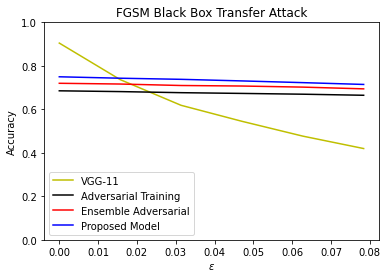

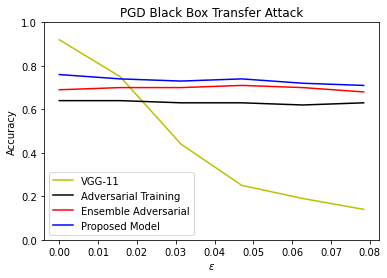

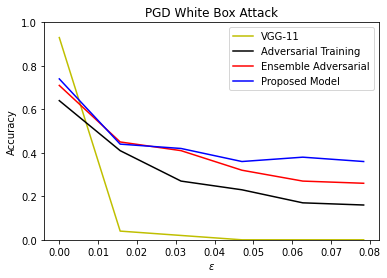

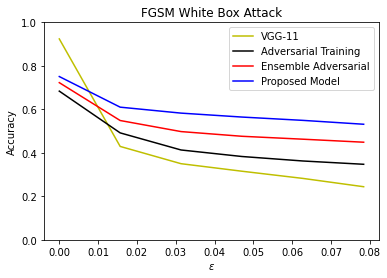

In [ ]:
import matplotlib.pyplot as plt
fig1 = plt.figure()
orig_fgsm_bb = [0.9047, 0.7367, 0.6186, 0.545, 0.4768, 0.4197]
adv_fgsm_bb = [0.6852, 0.6816, 0.6766, 0.6732, 0.6696, 0.6647]
advens_fgsm_bb = [0.7198, 0.7164, 0.7096, 0.7072, 0.7022, 0.6942]
new_fgsm_bb = [0.7497, 0.7431, 0.738, 0.7307, 0.7228, 0.7145]
plt.xlabel(r"$\epsilon$")
plt.ylabel("Accuracy")
plt.title("FGSM Black Box Transfer Attack")
plt.plot(eps_range, orig_fgsm_bb, '-y', label='VGG-11')
plt.plot(eps_range, adv_fgsm_bb, '-k', label='Adversarial Training')
plt.plot(eps_range, advens_fgsm_bb, '-r', label='Ensemble Adversarial')
plt.plot(eps_range, new_fgsm_bb, '-b', label='Proposed Model')
plt.ylim([0,1])
plt.legend()
plt.show()
fig1.savefig("fgsm_bb.png",dpi=300) 

fig2 = plt.figure()
orig_pgd_bb = [0.92, 0.75, 0.44, 0.25, 0.19, 0.14]
adv_pgd_bb = [0.64, 0.64, 0.63, 0.63, 0.62, 0.63]
advens_pgd_bb = [0.69, 0.7, 0.7, 0.71, 0.7, 0.68]
new_pgd_bb = [0.76, 0.74, 0.73, 0.74, 0.72, 0.71]
plt.xlabel(r"$\epsilon$")
plt.ylabel("Accuracy")
plt.title("PGD Black Box Transfer Attack")
plt.plot(eps_range, orig_pgd_bb, '-y', label='VGG-11')
plt.plot(eps_range, adv_pgd_bb, '-k', label='Adversarial Training')
plt.plot(eps_range, advens_pgd_bb, '-r', label='Ensemble Adversarial')
plt.plot(eps_range, new_pgd_bb, '-b', label='Proposed Model')
plt.ylim([0,1])
plt.legend()
plt.show()
fig2.savefig("pgd_bb.png",dpi=300)

fig3 = plt.figure()
orig_pgd_wb = [0.93, 0.04, 0.02, 0.0, 0.0, 0.0]
adv_pgd_wb = [0.64, 0.41, 0.27, 0.23, 0.17, 0.16]
advens_pgd_wb = [0.71, 0.45, 0.41, 0.32, 0.27, 0.26]
new_pgd_wb = [0.74, 0.44, 0.42, 0.36, 0.38, 0.36]
plt.xlabel(r"$\epsilon$")
plt.ylabel("Accuracy")
plt.title("PGD White Box Attack")
plt.plot(eps_range, orig_pgd_wb, '-y', label='VGG-11')
plt.plot(eps_range, adv_pgd_wb, '-k', label='Adversarial Training')
plt.plot(eps_range, advens_pgd_wb, '-r', label='Ensemble Adversarial')
plt.plot(eps_range, new_pgd_wb, '-b', label='Proposed Model')
plt.ylim([0,1])
plt.legend()
plt.show()
fig3.savefig("pgd_wb.png",dpi=300)


fig4 = plt.figure()
orig_fgsm_wb = [0.9239, 0.4294, 0.35, 0.3154, 0.2824, 0.2441]
adv_fgsm_wb = [0.6837, 0.4917, 0.4131, 0.3831, 0.3625, 0.3473]
advens_fgsm_wb = [0.7227, 0.5486, 0.4977, 0.4761, 0.4627, 0.4488]
new_fgsm_wb = [0.7508, 0.61, 0.5826, 0.5645, 0.5493, 0.5314]
plt.xlabel(r"$\epsilon$")
plt.ylabel("Accuracy")
plt.title("FGSM White Box Attack")
plt.plot(eps_range, orig_fgsm_wb, '-y', label='VGG-11')
plt.plot(eps_range, adv_fgsm_wb, '-k', label='Adversarial Training')
plt.plot(eps_range, advens_fgsm_wb, '-r', label='Ensemble Adversarial')
plt.plot(eps_range, new_fgsm_wb, '-b', label='Proposed Model')
plt.ylim([0,1])
plt.legend()
plt.show()
fig4.savefig("fgsm_wb.png",dpi=300)

In [ ]:
_pgd# TRANSFER ATTACK ON VGG!!_ADV

import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn 
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms


model = vgg11_adv

if torch.cuda.is_available():
  model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.001,momentum = 0.9,weight_decay = 0.006)

# FAST GRADIENT SIGN METHOD (FGSM)
def FGSM(test_loader,epsilon = 0.0625, min_val = -1, max_val = 1):
  correct = 0                
  adv_correct = 0
  misclassified = 0
  total = 0
  adv_noise =0 
  adverserial_images = []
  y_preds = []
  y_preds_adv = []
  test_images = []
  test_label = []
  
  for i, (images,labels) in enumerate(test_loader):
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
    images = Variable(images,requires_grad = True)
    labels = Variable(labels)
    
    outputs = mobilenet_v2_mod(images)
    loss =criterion(outputs,labels)

    model.zero_grad()
    if images.grad is not None:
      images.grad.data.fill_(0)
    loss.backward()
    
    grad = torch.sign(images.grad.data)
    images_adv = torch.clamp(images.data + epsilon*grad,min_val,max_val)     # x_adv = x + epsilon*grad
    
    adv_output = model(Variable(images_adv)) 
    _,predicted = torch.max(outputs.data,1)     
    _,adv_predicted = torch.max(adv_output.data,1) 
    
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    adv_correct += (adv_predicted == labels).sum().item()
    misclassified += (predicted != adv_predicted).sum().item()
    
    adverserial_images.extend((images_adv).cpu().data.numpy())
    y_preds.extend(predicted.cpu().data.numpy())
    y_preds_adv.extend(adv_predicted.cpu().data.numpy())
    test_images.extend(images.cpu().data.numpy())
    test_label.extend(labels.cpu().data.numpy())
    
    
  np.save('adverserial_images.npy',adverserial_images)    
  np.save('y_preds.npy',y_preds)
  np.save('y_preds_adv.npy',y_preds_adv)
  np.save('test_images.npy',test_images)
  np.save('test_label.npy',test_label)
  print('Accuracy of the model w/0 adverserial attack on test images is : {} %'.format(100*correct/total))
  print('Accuracy of the model with adverserial attack on test images is : {} %'.format(100* adv_correct/total))
  print('Number of misclassified examples(as compared to clean predictions): {}/{}'.format(misclassified,total))





    
  np.save('adverserial_images.npy',adverserial_images)
  np.save('y_preds.npy',y_preds)
  np.save('y_preds_adv.npy',y_preds_adv)
  np.save('test_images.npy',test_images)
  np.save('test_label.npy',test_label)
  print('Accuracy of the model w/0 adverserial attack on test images is : {} %'.format(100*correct/total))
  print('Accuracy of the model with adverserial attack on test images is : {} %'.format(100* adv_correct/total))
  print('Number of misclassified examples(as compared to clean predictions): {}/{}'.format(misclassified,total))


#i_FGSM(test_cifar_loader, iterations = 15,epsilon = 0.0625, min_val = -1,max_val = 1) 
FGSM(test_cifar_loader, epsilon = 0.0625, min_val = -2.11, max_val = 2.11)

Accuracy of the model w/0 adverserial attack on test images is : 46.37 %
Accuracy of the model with adverserial attack on test images is : 67.81 %
Number of misclassified examples(as compared to clean predictions): 6192/10000
Accuracy of the model w/0 adverserial attack on test images is : 46.37 %
Accuracy of the model with adverserial attack on test images is : 67.81 %
Number of misclassified examples(as compared to clean predictions): 6192/10000


In [ ]:
# TRANSFER ATTACK ON VGG!!_ADV

import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn 
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms


model = vgg11

if torch.cuda.is_available():
  model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.001,momentum = 0.9,weight_decay = 0.006)

# FAST GRADIENT SIGN METHOD (FGSM)
def FGSM(test_loader,epsilon = 0.0625, min_val = -1, max_val = 1):
  correct = 0                
  adv_correct = 0
  misclassified = 0
  total = 0
  adv_noise =0 
  adverserial_images = []
  y_preds = []
  y_preds_adv = []
  test_images = []
  test_label = []
  
  for i, (images,labels) in enumerate(test_loader):
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
    images = Variable(images,requires_grad = True)
    labels = Variable(labels)
    
    outputs = mobilenet_v2_mod(images)
    loss =criterion(outputs,labels)

    model.zero_grad()
    if images.grad is not None:
      images.grad.data.fill_(0)
    loss.backward()
    
    grad = torch.sign(images.grad.data)
    images_adv = torch.clamp(images.data + epsilon*grad,min_val,max_val)     # x_adv = x + epsilon*grad
    
    adv_output = model(Variable(images_adv)) 
    _,predicted = torch.max(outputs.data,1)     
    _,adv_predicted = torch.max(adv_output.data,1) 
    
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    adv_correct += (adv_predicted == labels).sum().item()
    misclassified += (predicted != adv_predicted).sum().item()
    
    adverserial_images.extend((images_adv).cpu().data.numpy())
    y_preds.extend(predicted.cpu().data.numpy())
    y_preds_adv.extend(adv_predicted.cpu().data.numpy())
    test_images.extend(images.cpu().data.numpy())
    test_label.extend(labels.cpu().data.numpy())
    
    
  np.save('adverserial_images.npy',adverserial_images)    
  np.save('y_preds.npy',y_preds)
  np.save('y_preds_adv.npy',y_preds_adv)
  np.save('test_images.npy',test_images)
  np.save('test_label.npy',test_label)
  print('Accuracy of the model w/0 adverserial attack on test images is : {} %'.format(100*correct/total))
  print('Accuracy of the model with adverserial attack on test images is : {} %'.format(100* adv_correct/total))
  print('Number of misclassified examples(as compared to clean predictions): {}/{}'.format(misclassified,total))




#  ITERATIVE - FGSM

def i_FGSM(test_loader,iterations = 1,epsilon = 0.1,min_val = -1,max_val = 1):
  correct = 0              
  adv_correct = 0
  misclassified = 0
  total = 0 
  adverserial_images = []
  y_preds = []
  y_preds_adv = []
  test_images = []
  test_label = []
  
  for i, (images,labels) in enumerate(test_loader):
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
      output_clean = model(Variable(images))
      # output_clean2 = model2(Variable(images))
      # output_clean3 = model3(Variable(images))
    images_adv = Variable(images.data,requires_grad = True)
    for j in range(iterations):  
      if torch.cuda.is_available():
        images_adv = images_adv.cuda()
      outputs = model(images_adv)
      # outputs2 = model2(images_adv)
      # outputs3 = model3(images_adv)
      loss = criterion(outputs,Variable(labels))
      # loss2 = criterion(outputs2,Variable(labels))
      # loss3 = criterion(outputs3,Variable(labels))
      model.zero_grad()
      # model2.zero_grad()
      # model3.zero_grad()
      if images_adv.grad is not None:
        images.adv.grad.data.fill_(0)
      loss.backward()
      grad = torch.sign(images_adv.grad.data)  
      images_adv = images_adv + (epsilon/iterations)*grad  

      images_adv = torch.where(images_adv > images + epsilon,images+epsilon,images_adv)
      images_adv = torch.where(images_adv < images-epsilon,images-epsilon,images_adv)
      images_adv = torch.clamp(images_adv,min_val,max_val)
      images_adv = Variable(images_adv.data,requires_grad = True)
      
    adv_output = model(Variable(images_adv))
    # adv_output2 = model2(Variable(images_adv))
    # adv_output3 = model3(Variable(images_adv))
    
    _,predicted = torch.max(output_clean.data,1)
    # _,predicted2 = torch.max(output_clean2.data,1)   
    # _,predicted3 = torch.max(output_clean3.data,1)      
    _,adv_predicted = torch.max(adv_output.data,1)
    # _,adv_predicted2 = torch.max(adv_output2.data,1) 
    # _,adv_predicted3 = torch.max(adv_output3.data,1)  
    
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    # correct2 += (predicted2 == labels).sum().item()
    # correct3 += (predicted3 == labels).sum().item()
    adv_correct += (adv_predicted == labels).sum().item()
    # adv_correct2 += (adv_predicted2 == labels).sum().item()
    # adv_correct3 += (adv_predicted3 == labels).sum().item()
    misclassified += (predicted != adv_predicted).sum().item()
    # misclassified2 += (predicted2 != adv_predicted2).sum().item()
    # misclassified3 += (predicted3 != adv_predicted3).sum().item()
    
    adverserial_images.extend((images_adv).cpu().data.numpy())
    y_preds.extend(predicted.cpu().data.numpy())
    y_preds_adv.extend(adv_predicted.cpu().data.numpy())
    test_images.extend(images.cpu().data.numpy())
    test_label.extend(labels.cpu().data.numpy())
    
  np.save('adverserial_images.npy',adverserial_images)
  np.save('y_preds.npy',y_preds)
  np.save('y_preds_adv.npy',y_preds_adv)
  np.save('test_images.npy',test_images)
  np.save('test_label.npy',test_label)
  print('Accuracy of the model w/0 adverserial attack on test images is : {} %'.format(100*correct/total))
  print('Accuracy of the model with adverserial attack on test images is : {} %'.format(100* adv_correct/total))
  print('Number of misclassified examples(as compared to clean predictions): {}/{}'.format(misclassified,total))


#i_FGSM(test_cifar_loader, iterations = 15,epsilon = 0.0625, min_val = -1,max_val = 1) 
FGSM(test_cifar_loader, epsilon = 0.0625, min_val = -2.11, max_val = 2.11)

Accuracy of the model w/0 adverserial attack on test images is : 46.37 %
Accuracy of the model with adverserial attack on test images is : 63.35 %
Number of misclassified examples(as compared to clean predictions): 6023/10000
